# Análisis exploratorio de datos

### **Objetivo**

El objetivo de este notebook es en primer lugar construir un dataset de forma manual preprocesando y compilando resultados de encuestas de particulares/hogares españoles sobre la consumición de diferentes categorías de comida. Después, se realizará **un análisis** para entender qué clases de comida tienen la mayor consumición en España, qué alimentos han tenido el mayor crecimiento en comparación con años anteriores, etc.

## 1) Contexto

**Propuesta de valor**

El objetivo de este trabajo es desarrollar una aplicación inteligente capaz de detectar los ingredientes disponibles en una nevera a partir de una foto y, al mismo tiempo, identificar síntomas y posibles deficiencias nutricionales a partir de una descripción anímica o física proporcionada por el usuario. Con esta información, la aplicación recomendará recetas que integren ambos contextos: ingredientes realmente disponibles y necesidades nutricionales potenciales.

**Alcance**

Dado que los recursos computacionales disponibles son limitados, resulta poco práctico intentar detectar todos los posibles ingredientes que un hogar podría tener en su nevera. Por ello, en `este proyecto se centrará en un conjunto reducido de 30 clases de alimentos: las 30 clases más consumidas en España, seleccionadas a partir de un análisis exploratorio de datos.`

**Diferenciación frente al mercado actual**

Existen aplicaciones que abordan parcialmente problemas similares, pero este proyecto propone un valor añadido diferencial:

- **Experiencia de usuario mejorada y sostenibilidad:** La mayoría de aplicaciones actuales se basan en el escaneo de códigos de barras para obtener valores nutricionales, o bien en sistemas donde el usuario selecciona manualmente los ingredientes disponibles. En contraste, este proyecto ofrece un proceso más natural y automático, donde basta con subir una foto de la nevera.
Además, el sistema priorizará recetas que usen esos ingredientes disponibles, contribuyendo a un uso más eficiente de los alimentos y reduciendo el desperdicio alimentario (ya que en otras aplicaciones, no hay una personalización a la hora de recomendar recetas y muchas veces el rankeo de recetas se basa en otros factores como popularidad). El sistema de recomendación combinará un modelo de puntuación y un LLM como juez final, aportando explicaciones personalizadas al usuario.

- **Enfoque en síntomas y deficiencias nutricionales:** Muchas veces el estado físico o anímico está relacionado con una dieta desequilibrada o carente de ciertos nutrientes. A diferencia de las aplicaciones que simplemente recomiendan dietas generales (pérdida de peso, bajas en carbohidratos, etc.), esta propuesta se centra en un nicho poco explorado y más personalizado a la situación de cada persona:
1) Interpretar la descripción del usuario (p. ej., “me siento cansado”) con un modelo NLP.
2) Asociar síntomas con posibles deficiencias nutricionales (p. ej., fatiga ↔ falta de hierro).
3) Recomendar recetas que incluyan alimentos disponibles en casa que puedan contribuir a cubrir dichas deficiencias.
4) Importante: la aplicación no diagnostica enfermedades, sino que ofrece recomendaciones alimentarias personalizadas y contextualizadas.

**Potencial a largo plazo**

Más allá del prototipo, la aplicación abre la puerta a generar datos con gran valor para el usuario y que pueda monitorizar sus tendencias de salud. La visión a futura es construir un sistema de base de datos integrado que alimentará a un dashboard final de tendencias de salud y consumo de alimentos/nutrientes para el usuario. Sigamos los siguientes ejemplos:

- Un usuario pide receta todos los días y también describe su estado de ánimo/físico -> en el dashboard observa que cada lunes, la aplicación ha predecido en base a su descripción de que padece fatiga → el usuario se da cuenta de que todos los lunes pasa por episodios de alto estrés -> el usuario puede tomar acción para lidiar con ello.
Estos patrones recurrentes podrían ayudar al propio usuario a identificar factores recurrentes en su vida cotidiana que contribuyen a sus síntomas, fomentando cambios positivos en sus hábitos.

Dado limitados recursos computacionales, es poco práctico intentar poder detectar todos los posibles ingredientes que los particulares o familias puedan tener en la nevera. Por lo tanto, se ha decidido reducir el alcance inicial para el prototipo de la aplicación. Se ha decidido realizar un análisis exploratorio de datos para escoger las 30 clases de comida más consumidas en España. 

## 2) Análisis exploratorio de datos

Dado que no hay datasets públicos o listos sobre los alimentos/ingredientes más consumidos por la población españolas sobre el cual realizar un análisis exploratorio de datos, se ha decidido construir manualmente un set de datos apropiado para el análisis exploratorio de datos combinando diferentes resultados de encuestas del Ministerio de Agricultura, Pesca y Alimentación (MAPA). La página web oficial de los resultados de encuestas es: https://www.mapa.gob.es/es/alimentacion/temas/consumo-tendencias/panel-de-consumo-alimentario/metodologia

La página de MAPA publica periodicamente resultados de encuentas que han realizado a particulares y hogares sobre consumo de diferentes tipos de comida. De los resultados, nos centraremos en las siguientes métricas específicas:
s datasets solo me quedaré con Penetración, Precio, ConsumoXCapita, GastoXCapita, Socioeconómico ConsumoXCapita, SocioEconómico Penetración
- Penetración % - hace referencia a porcentaje de individuos que han consumido el producto/categoria a lo largo del periodo de estudio
- Precio
- ConsumoXCapita - hace referencia a la cantidad de kg o litros consumidos por producto/categoria por habitante.
- GastoXCapita - hace referencia a gasto en euros por habitante por producto/categoria
- ConsumoXCápita por grupos socioeconómicos
- Pnetración % por grupos socioeconómicos

### 2.1) Imports

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
from io import BytesIO

sns.set_theme()

### 2.2) Construcción de dataset

La construcción del dataset manual se ha llevado de la siguiente forma:
- Se ha descargado los resultados de las encuestas anuales publicados en la página https://www.mapa.gob.es/es/alimentacion/temas/consumo-tendencias/panel-de-consumo-alimentario/series-anuales
- Se contruye una función llamada `dataset_grouping_preprocessing` que lee las diferentes hojas dentro de un archivo de excel para procesar los datos y guardarlos en el formato deseado. El preprocesamiento realizado es el siguiente:
    - Lee las hojas 'PENETRACIÓN', 'PRECIO', 'CONSUMOXCÁPITA' y 'GASTOXCÁPITA' y las transforma a formato largo (es decir, en lugar de formato pivot con muchas columnas, se pasa a formato melted) uniendo toda la información en un único DataFrame.
    - Lee las hojas socioeconómicas ('SOCIOECONÓMICO PENETRACIÓN', 'SOCIOECONÓMICO CONSUMOXCÁPITA') y transforma a formato largo y une en otro DataFrame.
    - Clasifica cada variable socioeconómica en un grupo (clase social, niños en el hogar, etc.) y añade esta información como una nueva columna.
- Se utiliza otra función llamada `read_and_process_zip` que abre un documento zip (se guardan los resultados descargados en un zip) y se itera sobre cada excel dentro del zip (hay uno por año, desde el 2010). 
    - La función `read_and_process_zip` llama a la función `dataset_grouping_preprocessing` definida previamente para transformar cada Excel anual en dos DataFrames (general y socioeconómico).
    - Extrae el año del nombre del archivo (primeros 4 caracteres) y lo añade como columna.
    - Almacena todos los DataFrames en una lista.
    - Finalmente concatena todos los resultados en dos DataFrames globales.

In [16]:
def dataset_grouping_preprocessing(file_path):
        
    """
    Procesa un archivo Excel con hojas de datos generales y socioeconómicos.

    Flujo
    --------------
    - Lee las hojas 'PENETRACIÓN', 'PRECIO', 'CONSUMOXCÁPITA' y 'GASTOXCÁPITA' 
      y las transforma a formato largo uniendo toda la información en un único DataFrame.
    - Lee las hojas socioeconómicas ('SOCIOECONÓMICO PENETRACIÓN', 'SOCIOECONÓMICO CONSUMOXCÁPITA') y transforma a formato largo y une en otro DataFrame.
    - Clasifica cada variable socioeconómica en un grupo (clase social, niños en el hogar, etc.) y añade esta información como una nueva columna.

    Parámetros
    ----------
    file_path : str
        Ruta al archivo Excel (o un objeto BytesIO si viene de un ZIP).

    Devuelve
    -------
    final_df_general : DataFrame
        Dataset con datos generales por comunidad autónoma.
    final_df_socioeconomico : DataFrame
        Dataset con datos socioeconómicos clasificados por grupo socioeconómico.
    """

    final_df_general = None
    final_df_socioeconomico = None

    excel_file = pd.ExcelFile(file_path)
    sheet_names = excel_file.sheet_names

    sheets_general = ['PENETRACIÓN', 'PRECIO', 'CONSUMOXCÁPITA', 'GASTOXCÁPITA']
    sheets_socioeconomico = ["SOCIOECONÓMICO PENETRACIÓN", "SOCIOECONÓMICO CONSUMOXCÁPITA"]
    if "SOCIOECONOMICO PENETRACION" in sheet_names and 'SOCIOECONÓMICO PENETRACIÓN' not in sheet_names:
        sheets_socioeconomico[sheets_socioeconomico.index('SOCIOECONÓMICO PENETRACIÓN')] = 'SOCIOECONOMICO PENETRACION'

    region_columns = [
        "NORESTE", "LEVANTE", "ANDALUCIA", "CENTRO-SUR",
        "CASTILLA Y LEON", "NOROESTE", "NORTE", "T.CANARIAS"
    ]
    to_exclude_cols = ["T.ESPAÑA"] + region_columns

    for sheet in sheets_general:
        df = pd.read_excel(file_path, sheet_name=sheet, header=2)
        df = df.rename(columns={'Unnamed: 0' : "Nombre original"})
        df_melted = pd.melt(df, id_vars=["Nombre original"], value_vars=df.columns[1:], var_name='CCAA', value_name=f'{sheet}').reset_index()

        if final_df_general is None:
            final_df_general = df_melted
        else:
            final_df_general = final_df_general.merge(df_melted, on=['index', 'Nombre original', 'CCAA'], how='left')

    for sheet in sheets_socioeconomico:
        df_socioeconomico = pd.read_excel(file_path, sheet_name=sheet, header=2)
        df_socioeconomico = df_socioeconomico.rename(columns={'Unnamed: 0' : "Nombre original"})
        df_socioeconomico = df_socioeconomico[[col for col in df_socioeconomico.columns if col not in to_exclude_cols]]
        df_melted_socioeconomico = pd.melt(df_socioeconomico, id_vars=['Nombre original'], value_vars=df_socioeconomico.columns[1:],
                                           var_name='var_socioeconomica',value_name=f'{sheet}').reset_index()

        if final_df_socioeconomico is None:
            final_df_socioeconomico = df_melted_socioeconomico
        else:
            final_df_socioeconomico = final_df_socioeconomico.merge(df_melted_socioeconomico, how='left', on=['index', 'Nombre original', 'var_socioeconomica'])
        
    categorias = {
    "Clase social": df_socioeconomico.columns[1:6],
    "Niños en el hogar": df_socioeconomico.columns[6:9],
    "Actividad compra": df_socioeconomico.columns[9:11],
    "Edad responsable": df_socioeconomico.columns[11:16],
    "Tamaño de hogar": df_socioeconomico.columns[16:20],
    "Tamaño de hábitat": df_socioeconomico.columns[20:25],
    "Tipo de hogar": df_socioeconomico.columns[25:34]}

    # Construir un diccionario inverso columna → grupo
    col_to_categoria = {
        col: grupo
        for grupo, cols in categorias.items()
        for col in cols
    }
    
    final_df_socioeconomico['grupo_socioeconomica'] = final_df_socioeconomico['var_socioeconomica'].map(col_to_categoria)

    return final_df_general, final_df_socioeconomico 

In [17]:
def read_and_process_zip(zip_url):

    """
    Procesa un archivo ZIP que contiene varios Excels con la misma estructura.

    Parámetros
    ----------
    zip_url : str
        Ruta al archivo ZIP que contiene varios ficheros Excel.

    Funcionamiento
    --------------
    - Itera por cada archivo Excel dentro del ZIP.
    - Llama a la función `dataset_grouping_preprocessing` definida previamente para transformar cada Excel anual en dos DataFrames (general y socioeconómico).
    - Extrae el año del nombre del archivo (primeros 4 caracteres) y lo añade como columna.
    - Almacena todos los DataFrames en una lista.
    - Finalmente concatena todos los resultados en dos DataFrames globales.

    Retorna
    -------
    final_general_df : DataFrame
        Dataset combinado con toda la información general de todos los años.
    final_socioeconomico_df : DataFrame
        Dataset combinado con toda la información socioeconómica de todos los años.
    """

    zip_results = []
    with zipfile.ZipFile(zip_url, 'r') as zip_file:
        for file_name in zip_file.namelist():
            print(f"Procesando {file_name}...")
            with zip_file.open(file_name) as f:
                file_like = BytesIO(f.read())
                general_df, socioeconomico_df = dataset_grouping_preprocessing(file_like)

                #Se obtienen las primeras 4 letras (que son números), corresponden al año del dataset
                #Se creará una columna posteriormente en cada df para señalizar el año del dataset

                year = int(file_name[:4])
                
                general_df['dataset_year'] = year
                socioeconomico_df['dataset_year'] = year

                zip_results.append({
                    'general': general_df,
                    'socioeconomico': socioeconomico_df
                    })
                
    #Combino todos los dfs haciendo union en dos finales
    final_general_df = pd.concat([result['general'] for result in zip_results], ignore_index=True)
    final_socioeconomico_df = pd.concat([result['socioeconomico'] for result in zip_results], ignore_index=True)
     
    print('Se han leído todos los archivos del zip, COMPLETADO')
    return final_general_df, final_socioeconomico_df

In [18]:
# Usando las dos funciones para construir el dataset
zip_url = '..\dataset\EDA - Spain food preference dataset\dataset_anual_consumo_alimentario_España_2010a2024.zip'
final_general_df, final_socioeconomico_df = read_and_process_zip(zip_url=zip_url)

Procesando 2011datosanualesdelpaneldeconsumoalimentarioenhogares.xlsx...
Procesando 2012datosanualesdelpaneldeconsumoalimentarioenhogares.xlsx...
Procesando 2013datosanualesdelpaneldeconsumoalimentarioenhogares.xlsx...
Procesando 2014datosanualesdelpaneldeconsumoalimentarioenhogares.xlsx...
Procesando 2015datosanualesdelpaneldeconsumoalimentarioenhogares.xlsx...
Procesando 2016datosanualesdelpaneldeconsumoalimentarioenhogares.xlsx...
Procesando 2017datosanualesdelpaneldeconsumoalimentarioenhogares.xlsx...
Procesando 2018datosanualesdelpaneldeconsumoalimentarioenhogares.xlsx...
Procesando 2019datosanualesdelpaneldeconsumoalimentarioenhogares.xlsx...
Procesando 2020datosanualesdelpaneldeconsumoalimentarioenhogares.xlsx...
Procesando 2021datosanualesdelpaneldeconsumoalimentarioenhogares.xlsx...
Procesando 2022-datos-anuales-panel-consumo-hogares-base2021.xlsx...
Procesando 2023-datos-anuales-panel-consumo-hogares-base2021.xlsx...
Procesando 2024datosanualesdelpaneldeconsumoalimentarioenho

### 2.3) Codificación manual

Adicionalmente a construir el dataset, se ha cogido los resultados anuales del 2024 **como referencia** para realizar una codificación manual y pre-filtrado de algunas fials en los resultados de las encuestas que no proporcionan información valiosa para el EDA que se va a realizar. Se han construido las siguientes columnas:
- **Categoría:** En categoría, a cada fila de producto o alimento se le asigna un número del 0 al 3.
    - 0: Significa que la fila es demasiado genérica para ser útil. Por ejemplo: penetración % en total alimentación, total carnes. Estas filas se deben eliminar dado que no proporcionan información.
    - 1: Significa que la fila es representativa y se debe mantener. Por ejemplo: miel, huevos, etc. Estas filas se deben mantener.
    - 2: Significa que la fila es demasiado específica. Por ejemplo: huevos a granel (con huevos es suficiente), huevos envasados. Estas filas se deben eliminar.
    - 3: Significa que la fila no proporciona demasiado valor. Por ejemplo: otras carnes, otras aves (no se sabe qué aves ni que carnes pro ejemplo). Estas filas se deben eliminar.
- **Nombre refinado:** A los alimentos con categoría 1 (representativos) se les asigna un nombre para mejor entendimiento. 
    - Por ejemplo T.HUEVOS KGS -> Huevos
    - Sardinas (cuando el dataset está haciendo referencia a conservas) -> Conservas sardina
- **Categoría comida:** Para poder realizar un EDA efectivo y que proporcione insights, se ha reducido la dimensionalidad de los nombres en grupos basados en la nutrición piramidal.
    - Por ejemplo, huevos --> Lácteos, Derivados y Huevos
    - Bacalao --> pescados y mariscos

Una vez hecha la codificación con 2024 (con las categorías más recientes), podemos simplemente hacer `merge` para que las filas de todos los años reciban las codificaciones

In [19]:
# Proceso de codificación manual mencionado previamente
manual_labelling_df = pd.read_excel(r'..\dataset\EDA - Spain food preference dataset\Dataset manual - Clasificacion de alimentos.xlsx')
manual_labelling_df.head(10)

Nombre original  Categoría Nombre Refinado  \
0   .TOTAL ALIMENTACION          0             NaN   
1          T.HUEVOS KGS          0             NaN   
2        T.HUEVOS UNDS.          1          Huevos   
3  TOTAL HUEVOS GALLINA          2             NaN   
4            OTRAS AVES          2             NaN   
5                  MIEL          1            Miel   
6                GRANEL          2             NaN   
7              ENVASADA          2             NaN   
8           TOTAL CARNE          0             NaN   
9     CARNE CERTIFICADA          3             NaN   

              Categoría comida  
0                          NaN  
1                          NaN  
2  Lácteos, Derivados y Huevos  
3                          NaN  
4                          NaN  
5           Otros/Complementos  
6                          NaN  
7                          NaN  
8                          NaN  
9                          NaN

In [20]:
# Uno la codificación de manual_labelling_df a los dos dfs generados por las funciones de preprocesamiento, se filtrarán todos los alimentos que no hayan sido clasificados como Categoría 1 porque no nos interesan.
final_general_df = pd.merge(final_general_df, manual_labelling_df, on='Nombre original', how='left')
final_socioeconomico_df = pd.merge(final_socioeconomico_df, manual_labelling_df, on='Nombre original', how='left')

## 3) Análisis de DataFrame con datos generales

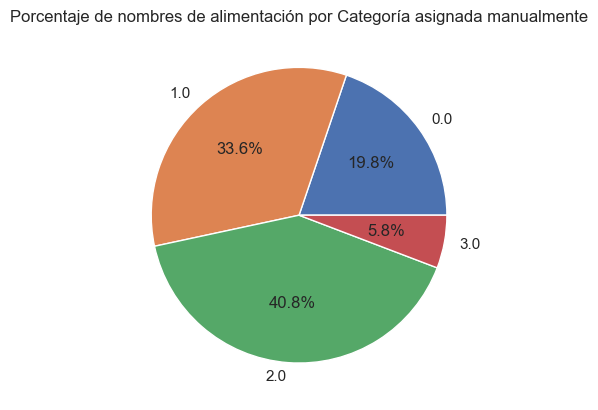

In [21]:
sizes_df = final_general_df.groupby(['dataset_year','Categoría']).size().reset_index(name='size')

fig, ax = plt.subplots()
ax.pie(sizes_df[sizes_df.dataset_year == 2024]['size'], labels=sizes_df[sizes_df.dataset_year == 2024]['Categoría'], autopct='%1.1f%%')
plt.title('Porcentaje de nombres de alimentación por Categoría asignada manualmente')
plt.show()


Podemos observar que del dataset, solo un 33.6% de filas han sido codificadas como categoría 1 (esta categoría significa que el nombre del alimento en sí es representativo y útil). Las filas que caen en el resto de categorías se eliminan.

In [22]:
# Miramos los tamaños (o la cantidad de filas) antes de filtrar
final_general_df.groupby(['dataset_year', 'Categoría']).size()

dataset_year  Categoría
2010          0.0          1638
              1.0          5564
              2.0          5408
              3.0           962
2011          0.0          1638
              1.0          5564
              2.0          5408
              3.0           962
2012          0.0          1638
              1.0          5564
              2.0          5408
              3.0           962
2013          0.0          1690
              1.0          6058
              2.0          6630
              3.0          1014
2014          0.0          1690
              1.0          6058
              2.0          6630
              3.0          1014
2015          0.0          1690
              1.0          6058
              2.0          6630
              3.0          1014
2016          0.0          1690
              1.0          6058
              2.0          6630
              3.0          1014
2017          0.0          1690
              1.0          6058
              2.

In [23]:
# Filtraremos todas las filas que no sean categorizados como 1 en el dataset.

filtered_general_df = final_general_df[final_general_df['Categoría'] == 1]
filtered_general_df.head()

index     Nombre original      CCAA  PENETRACIÓN    PRECIO  \
2       2      T.HUEVOS UNDS.  T.ESPAÑA    70.682500  0.123097   
7       6                MIEL  T.ESPAÑA     6.459167  5.280797   
13     12  SALCHICHAS FRESCAS  T.ESPAÑA    12.725833  6.418962   
14     13        CARNE VACUNO  T.ESPAÑA    52.575000  9.027366   
18     17         CARNE POLLO  T.ESPAÑA    70.785000  4.015438   

    CONSUMOXCÁPITA  GASTOXCÁPITA  dataset_year  Categoría     Nombre Refinado  \
2       130.984434     16.123740          2011        1.0              Huevos   
7         0.438368      2.314934          2011        1.0                Miel   
13        0.648186      4.160681          2011        1.0  Salchichas frescas   
14        6.577153     59.374366          2011        1.0        Carne vacuno   
18       14.550497     58.426616          2011        1.0         Carne pollo   

               Categoría comida  
2   Lácteos, Derivados y Huevos  
7            Otros/Complementos  
13                       Carnes  
14                       Carnes  
18                       Carnes

A continuación, realizaremos los siguientes análisis:
- Top 10 alimentos para cada variable (penetración, precio, etc.) en cada categoría comida (carnes, pescado, etc.)
- Top 10 categorías de comida con mayor crecimiento anual


### 3.1) Top 10 alimentos en cada categoría de comida 

In [24]:
spain_df = filtered_general_df[filtered_general_df['CCAA'] == 'T.ESPAÑA'] # Solo necesitamos los datos de España y no por comunidad autónoma

Definimos una función para poder graficar luego

In [25]:
sns.set_palette('tab10')
def plot_top10(metric):
    df = spain_df.groupby(['Categoría comida', 'Nombre Refinado'])[metric].mean().reset_index().sort_values(by=metric, ascending=False).groupby('Categoría comida').head(10).sort_values(by=['Categoría comida', metric], ascending=False)

    num_categories = len(df['Categoría comida'].unique())

    fig, axes = plt.subplots(4,3, figsize=(18, 20)) 
    axes = axes.flatten()

    for idx, group in enumerate(df['Categoría comida'].unique()):
        group_df = df[df['Categoría comida'] == group]  
        sns.barplot(data=group_df, x='Nombre Refinado', y=metric, hue='Nombre Refinado', ax=axes[idx])
        
        axes[idx].set_title(f"Top 10 de {group} por {metric}")
        axes[idx].tick_params(axis='x', rotation=80)
        axes[idx].set_xlabel('')
        
        # Añado texto a las barras
        for p in axes[idx].patches:
            axes[idx].annotate(f'{p.get_height():.2f}', 
                               (p.get_x() + p.get_width() / 2., p.get_height()), 
                               xytext=(0, 5), 
                               textcoords='offset points',
                               ha='center', va='bottom', fontsize=10, color='black')

    for j in range(num_categories, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


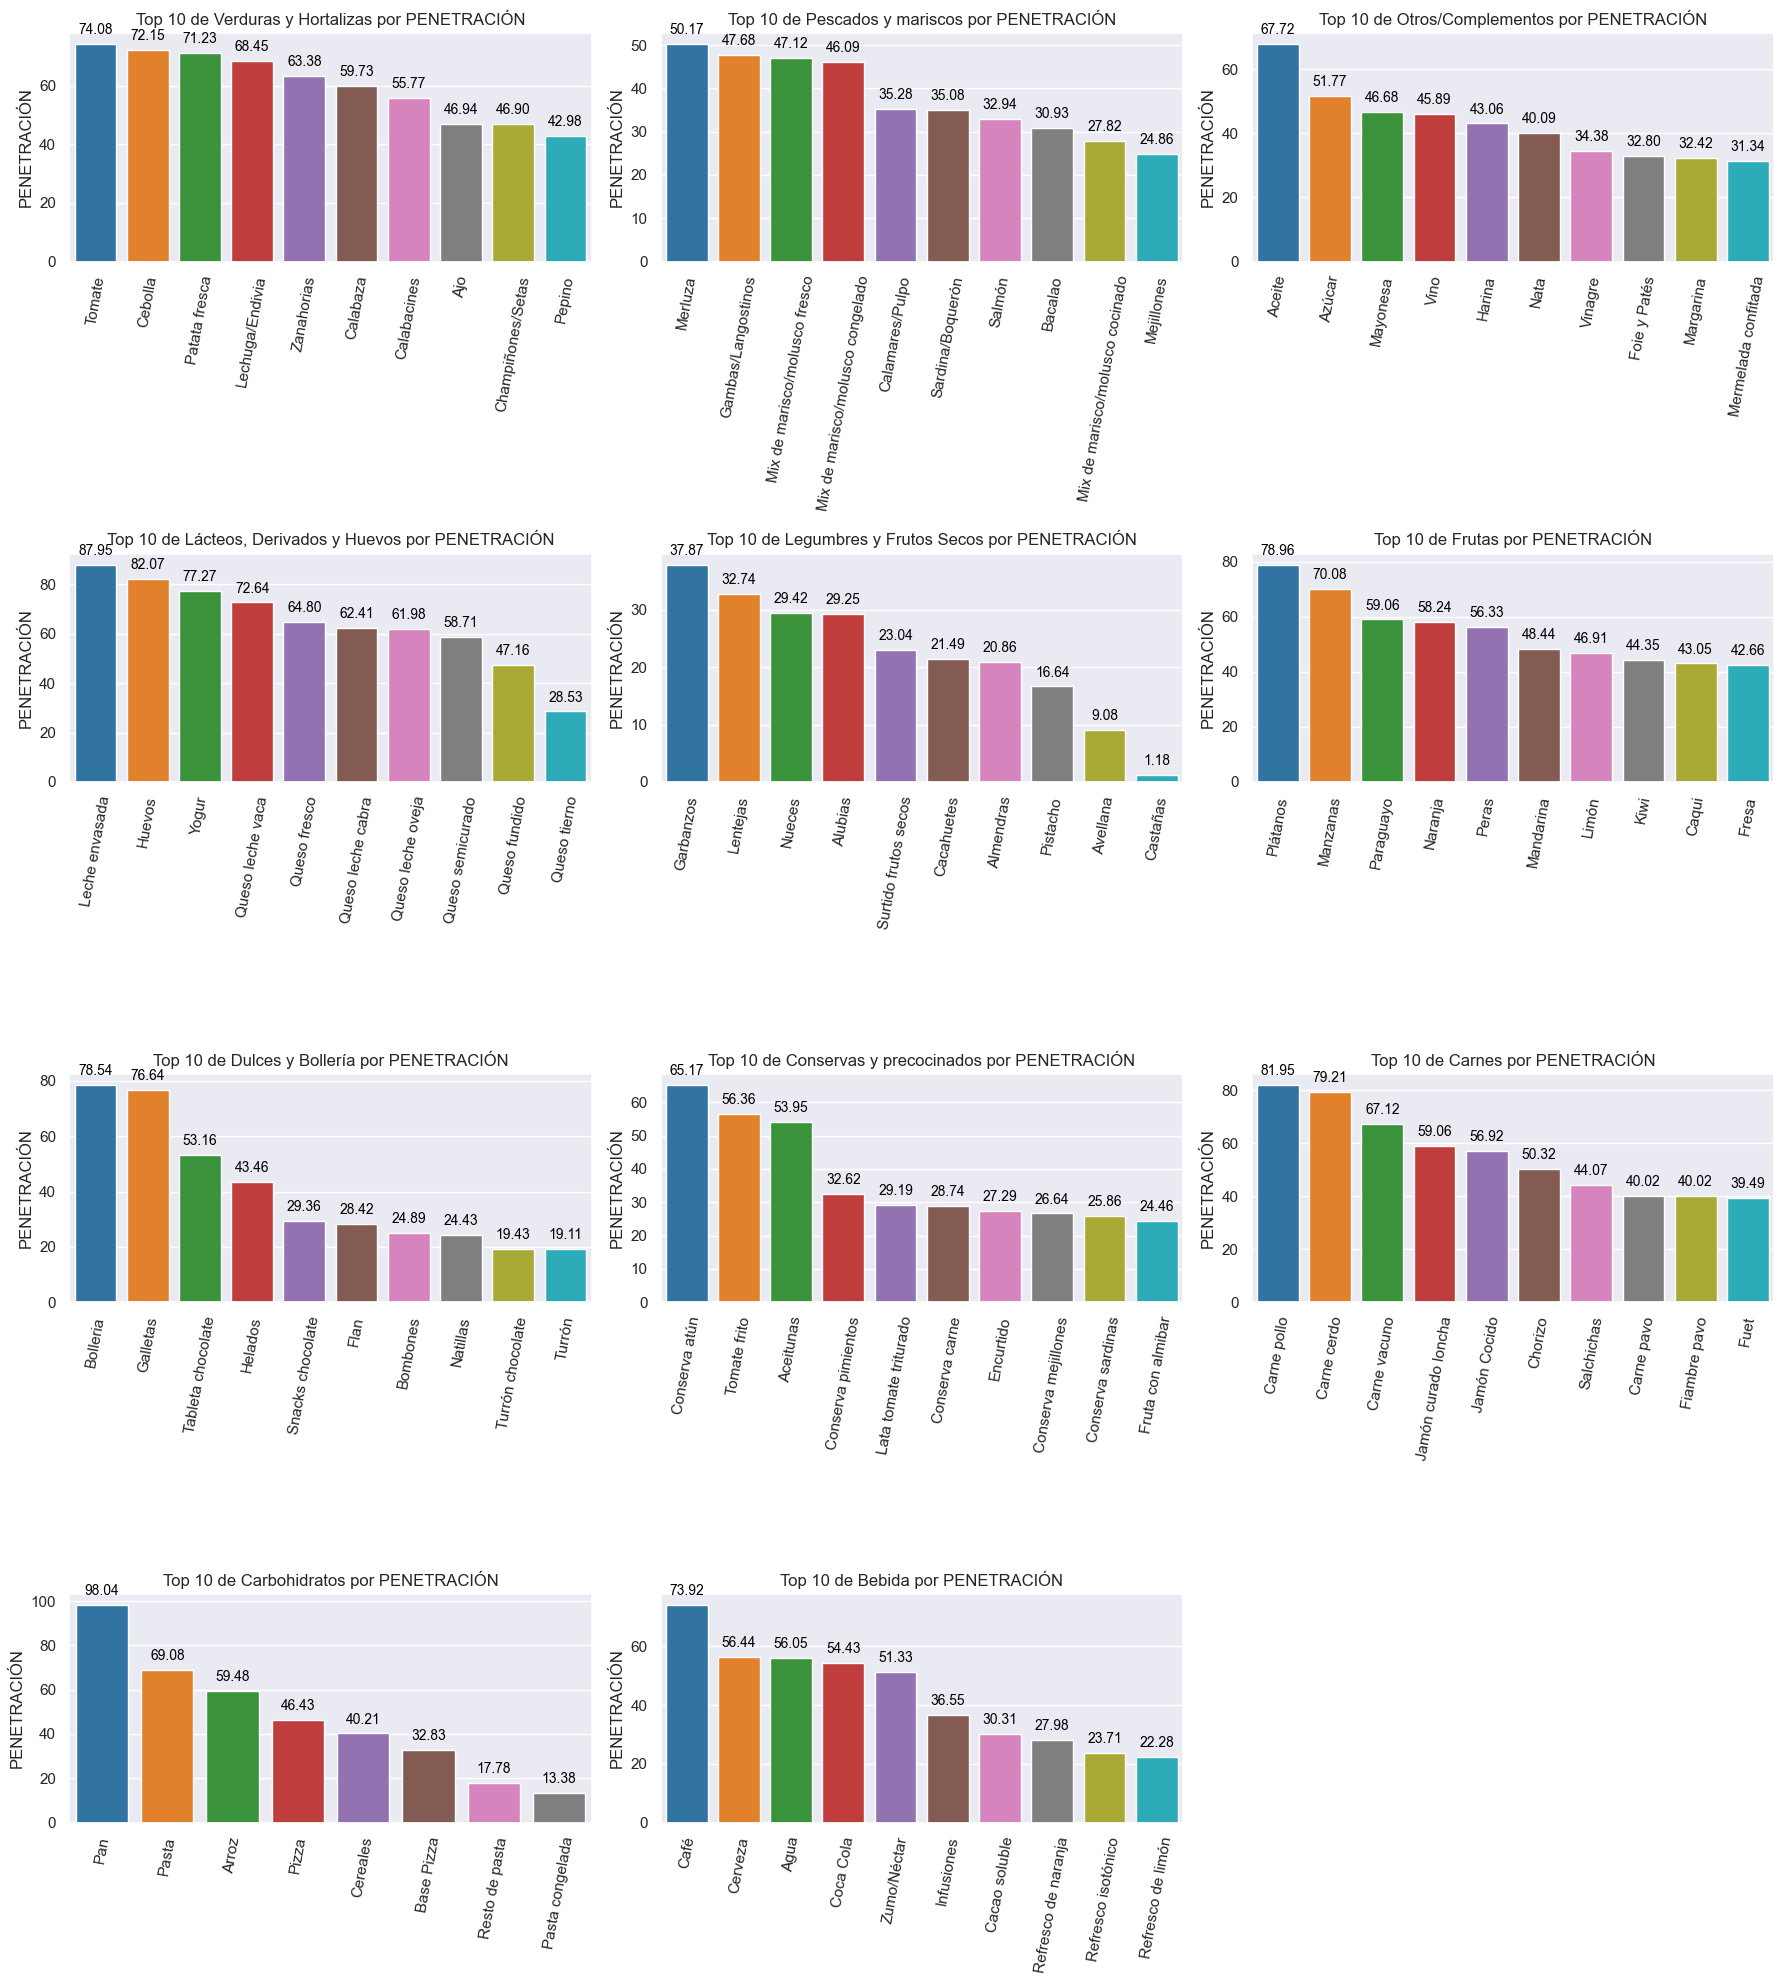

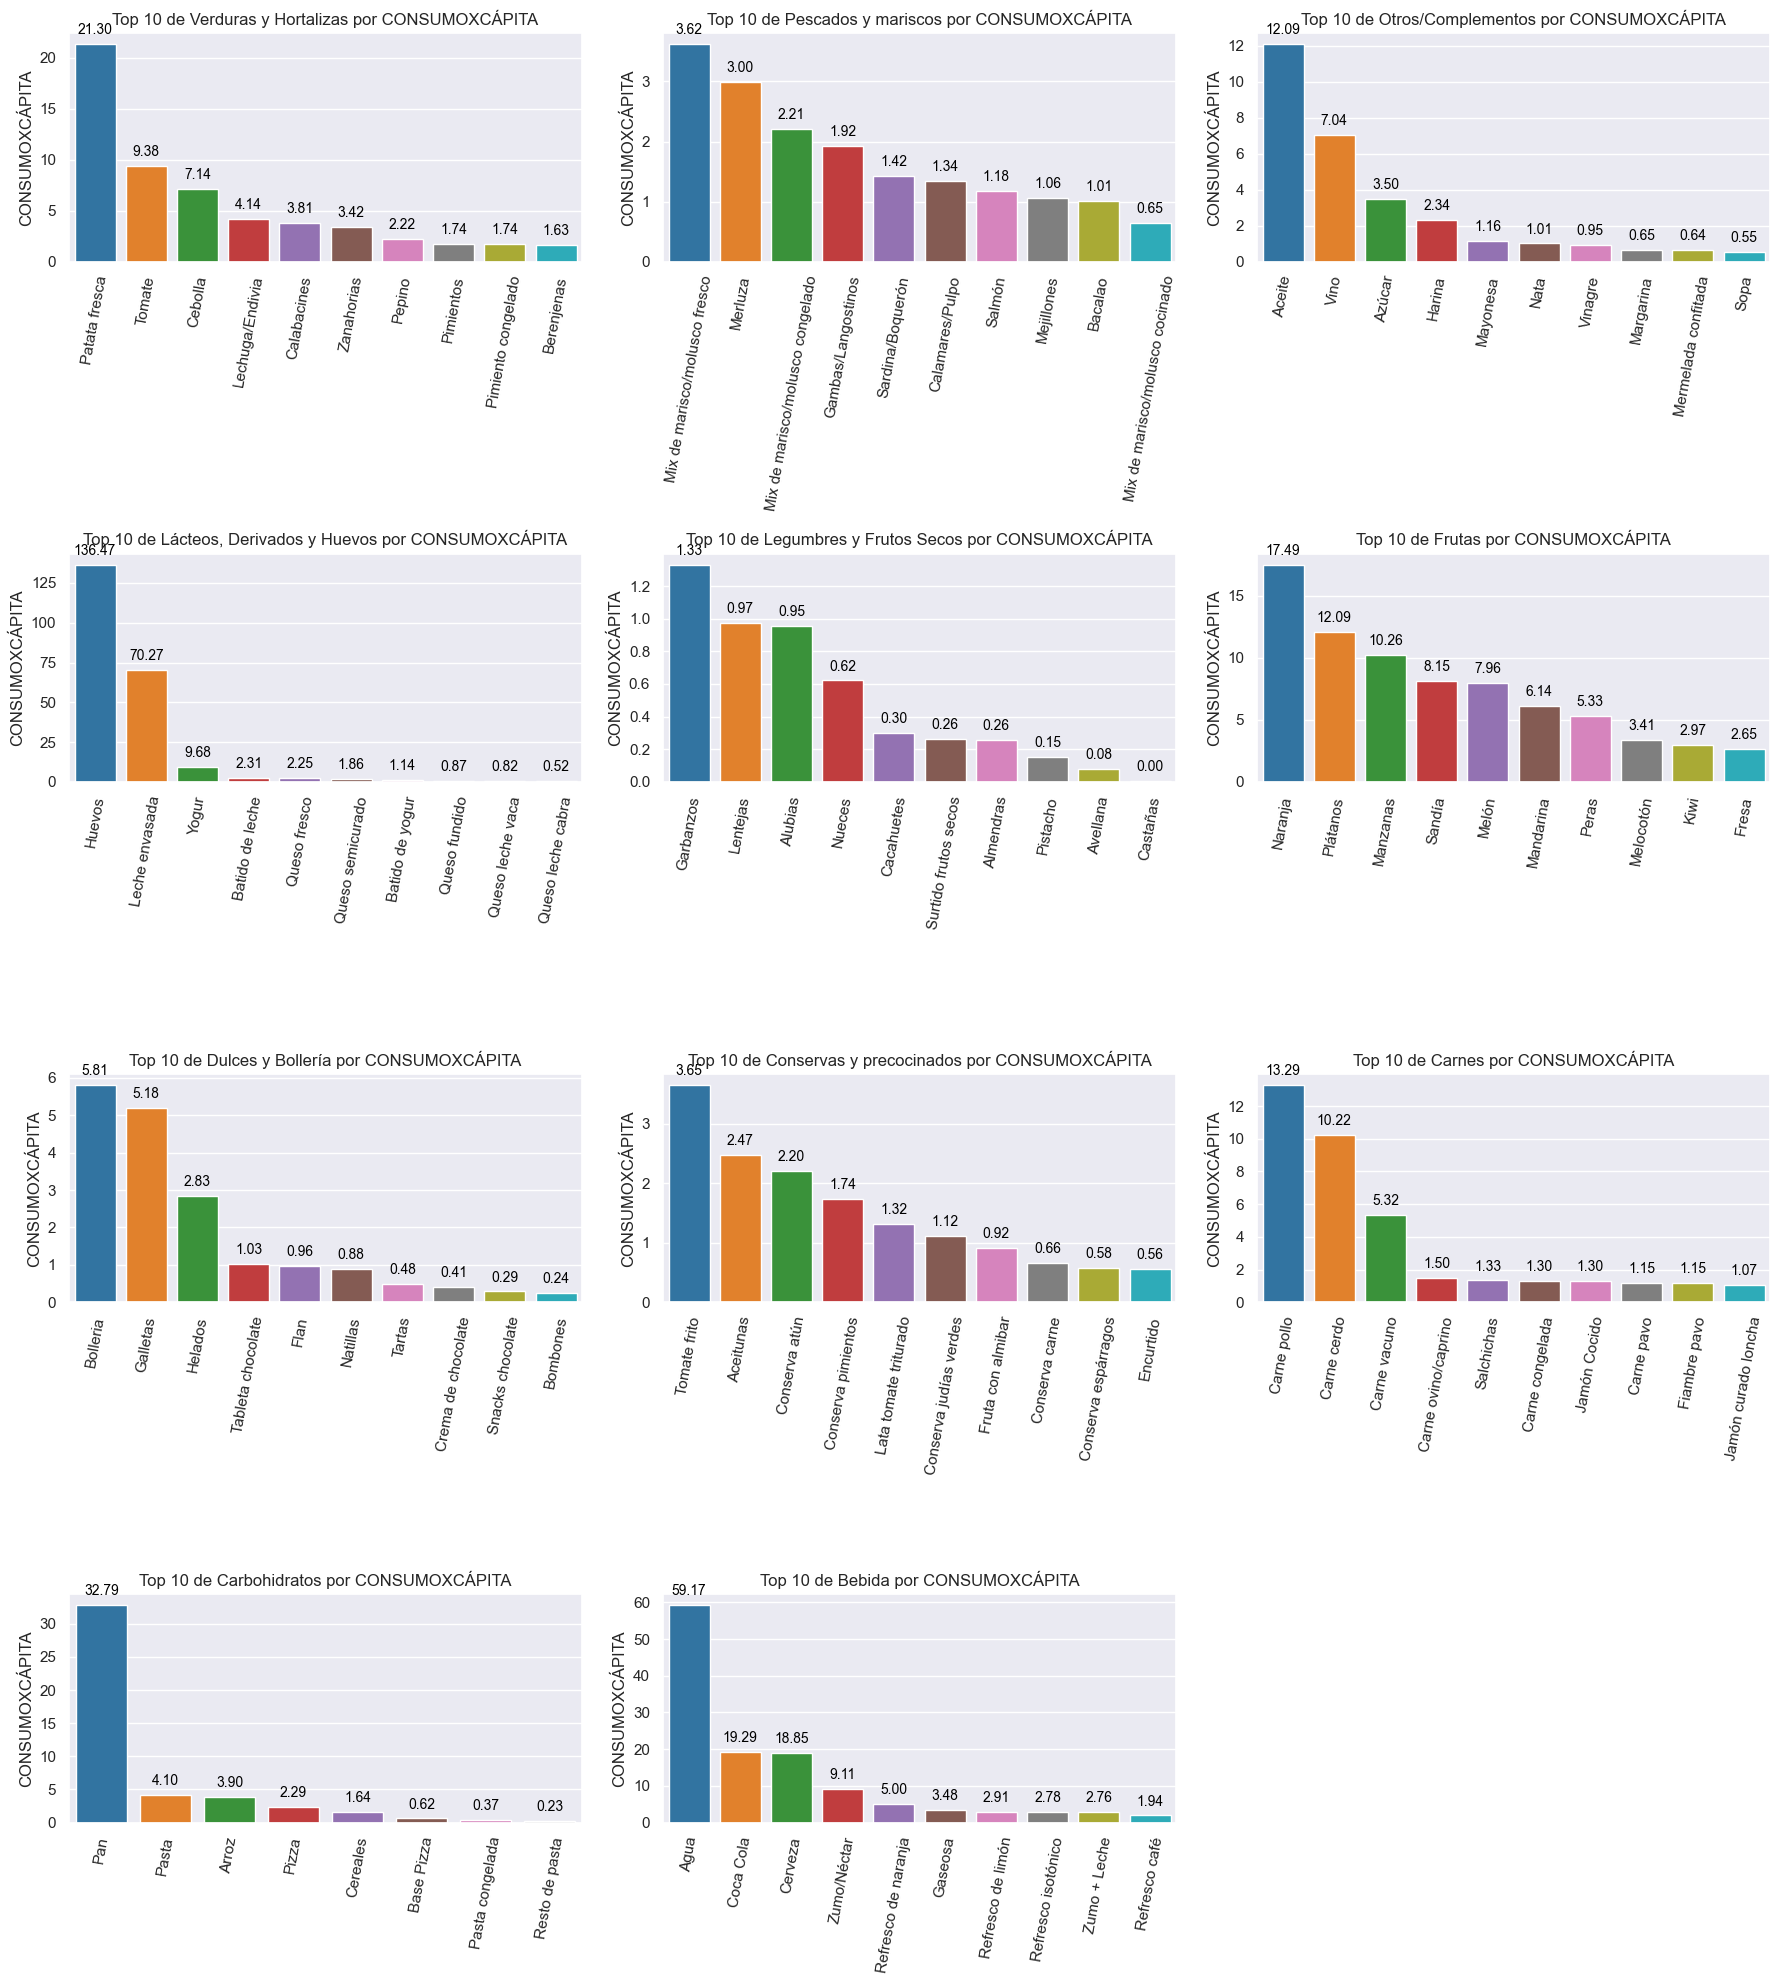

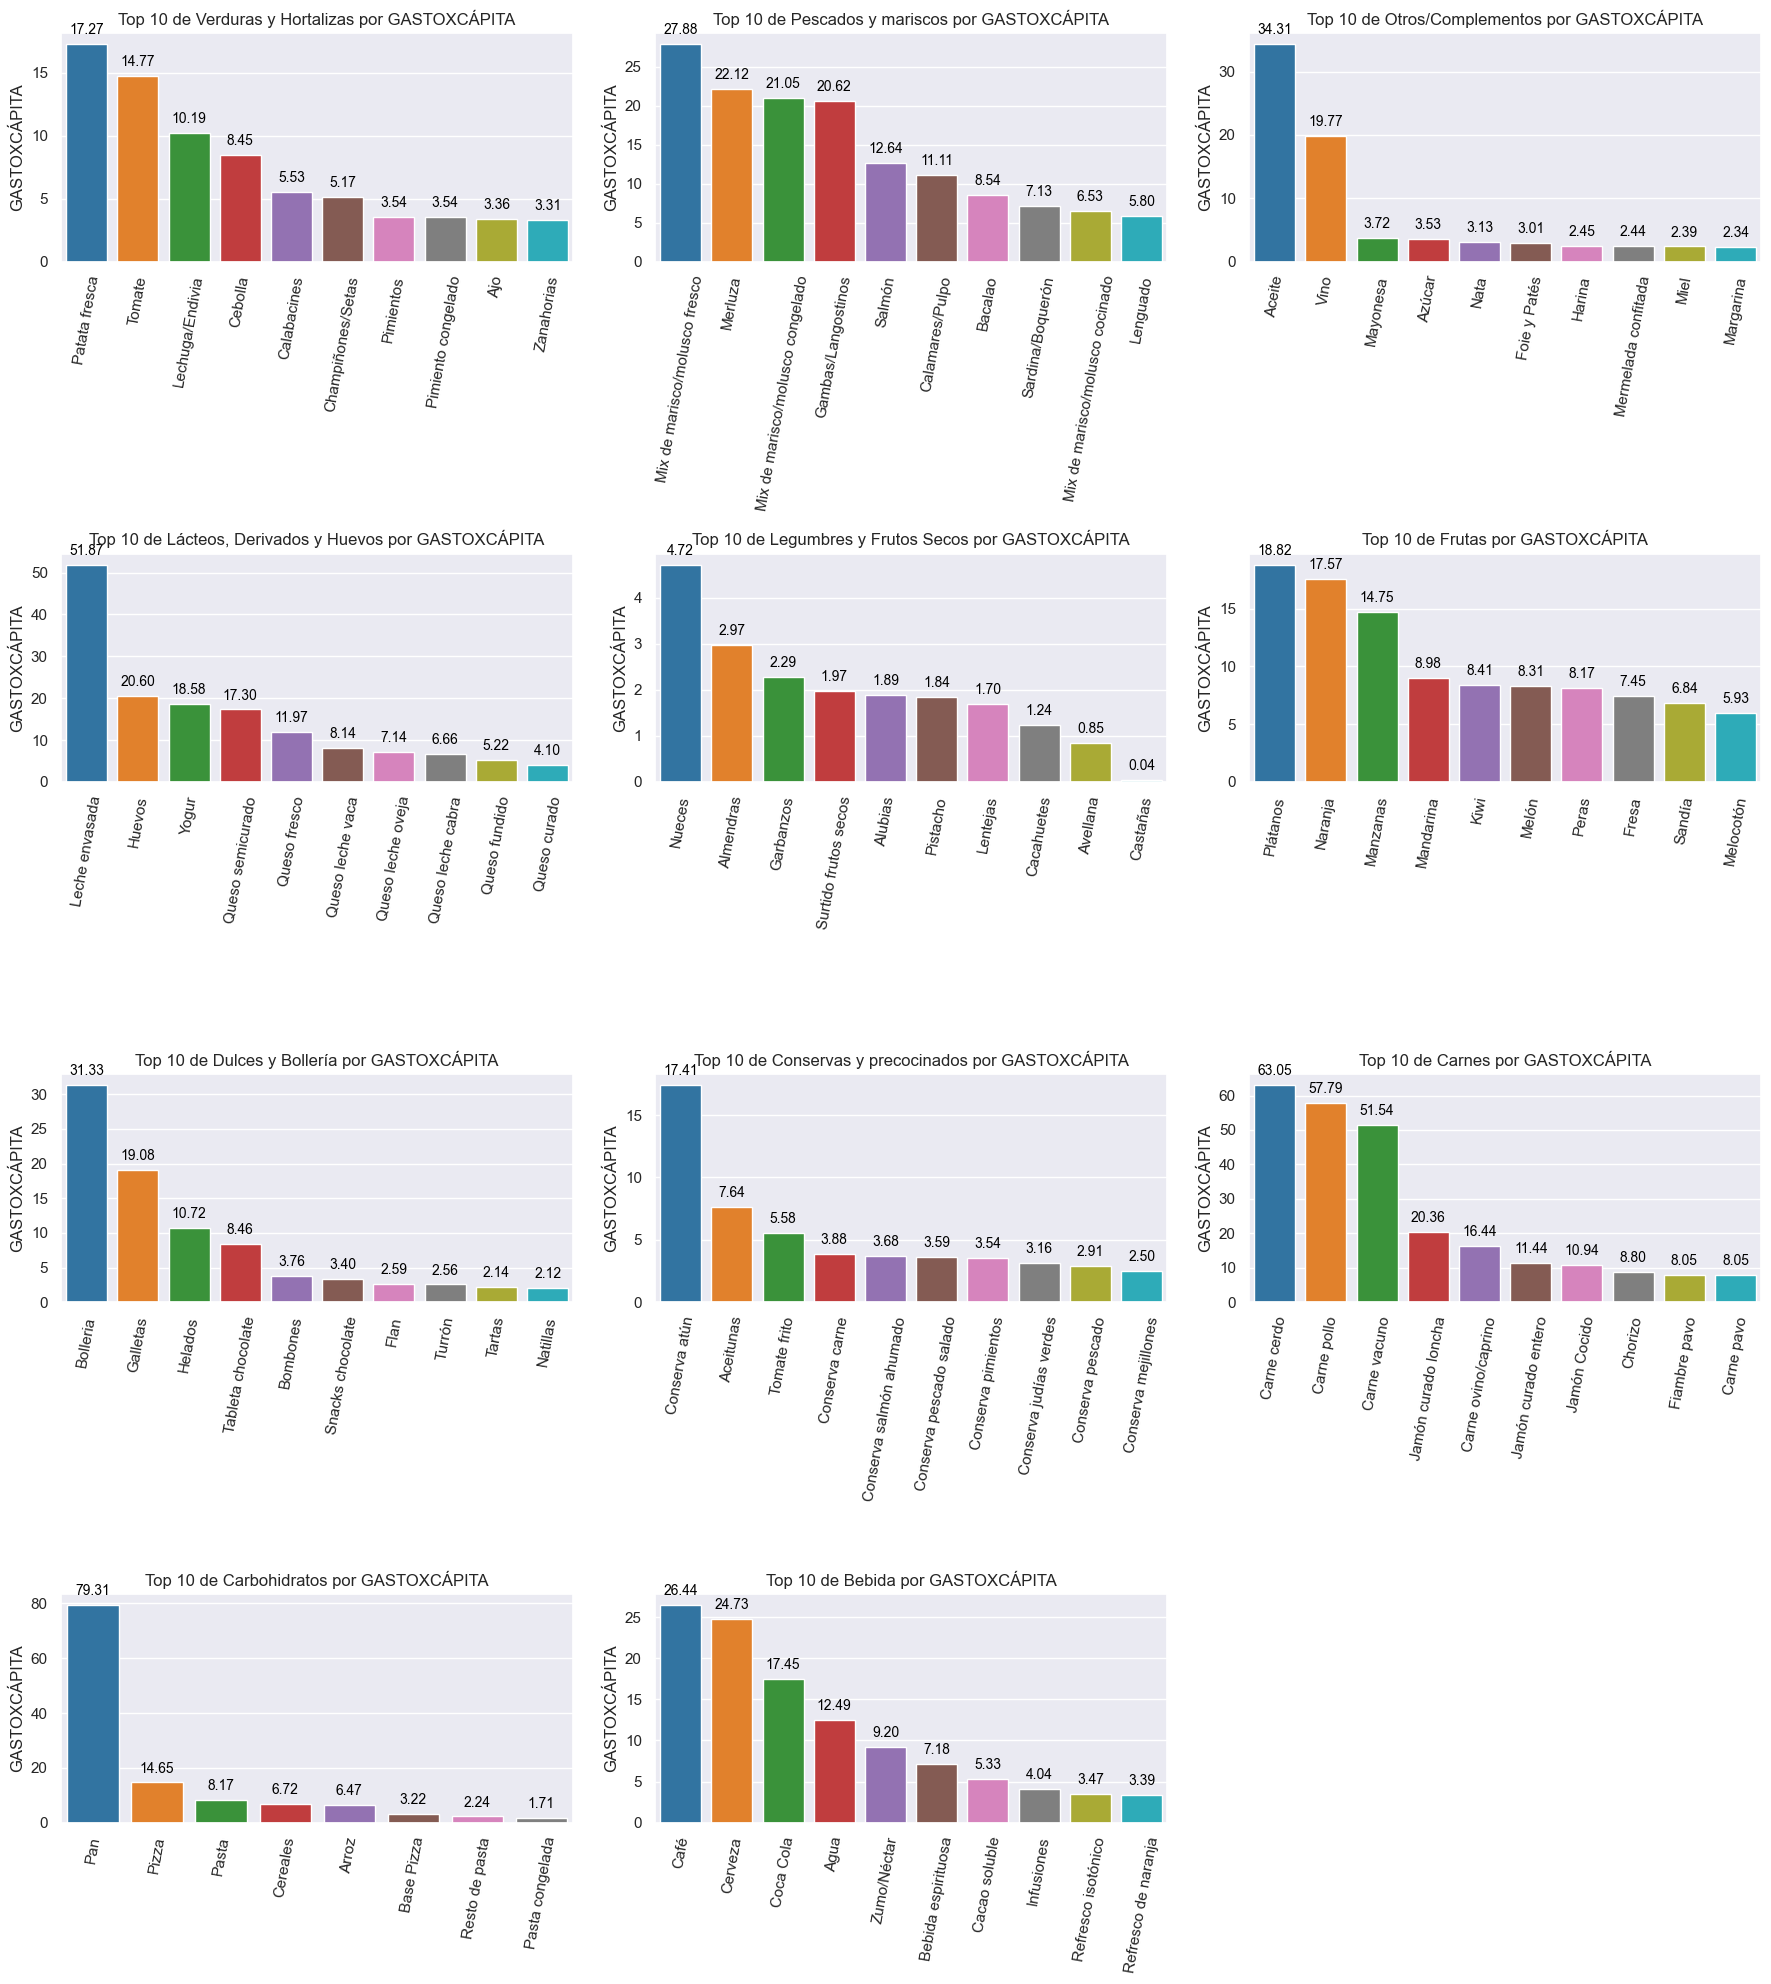

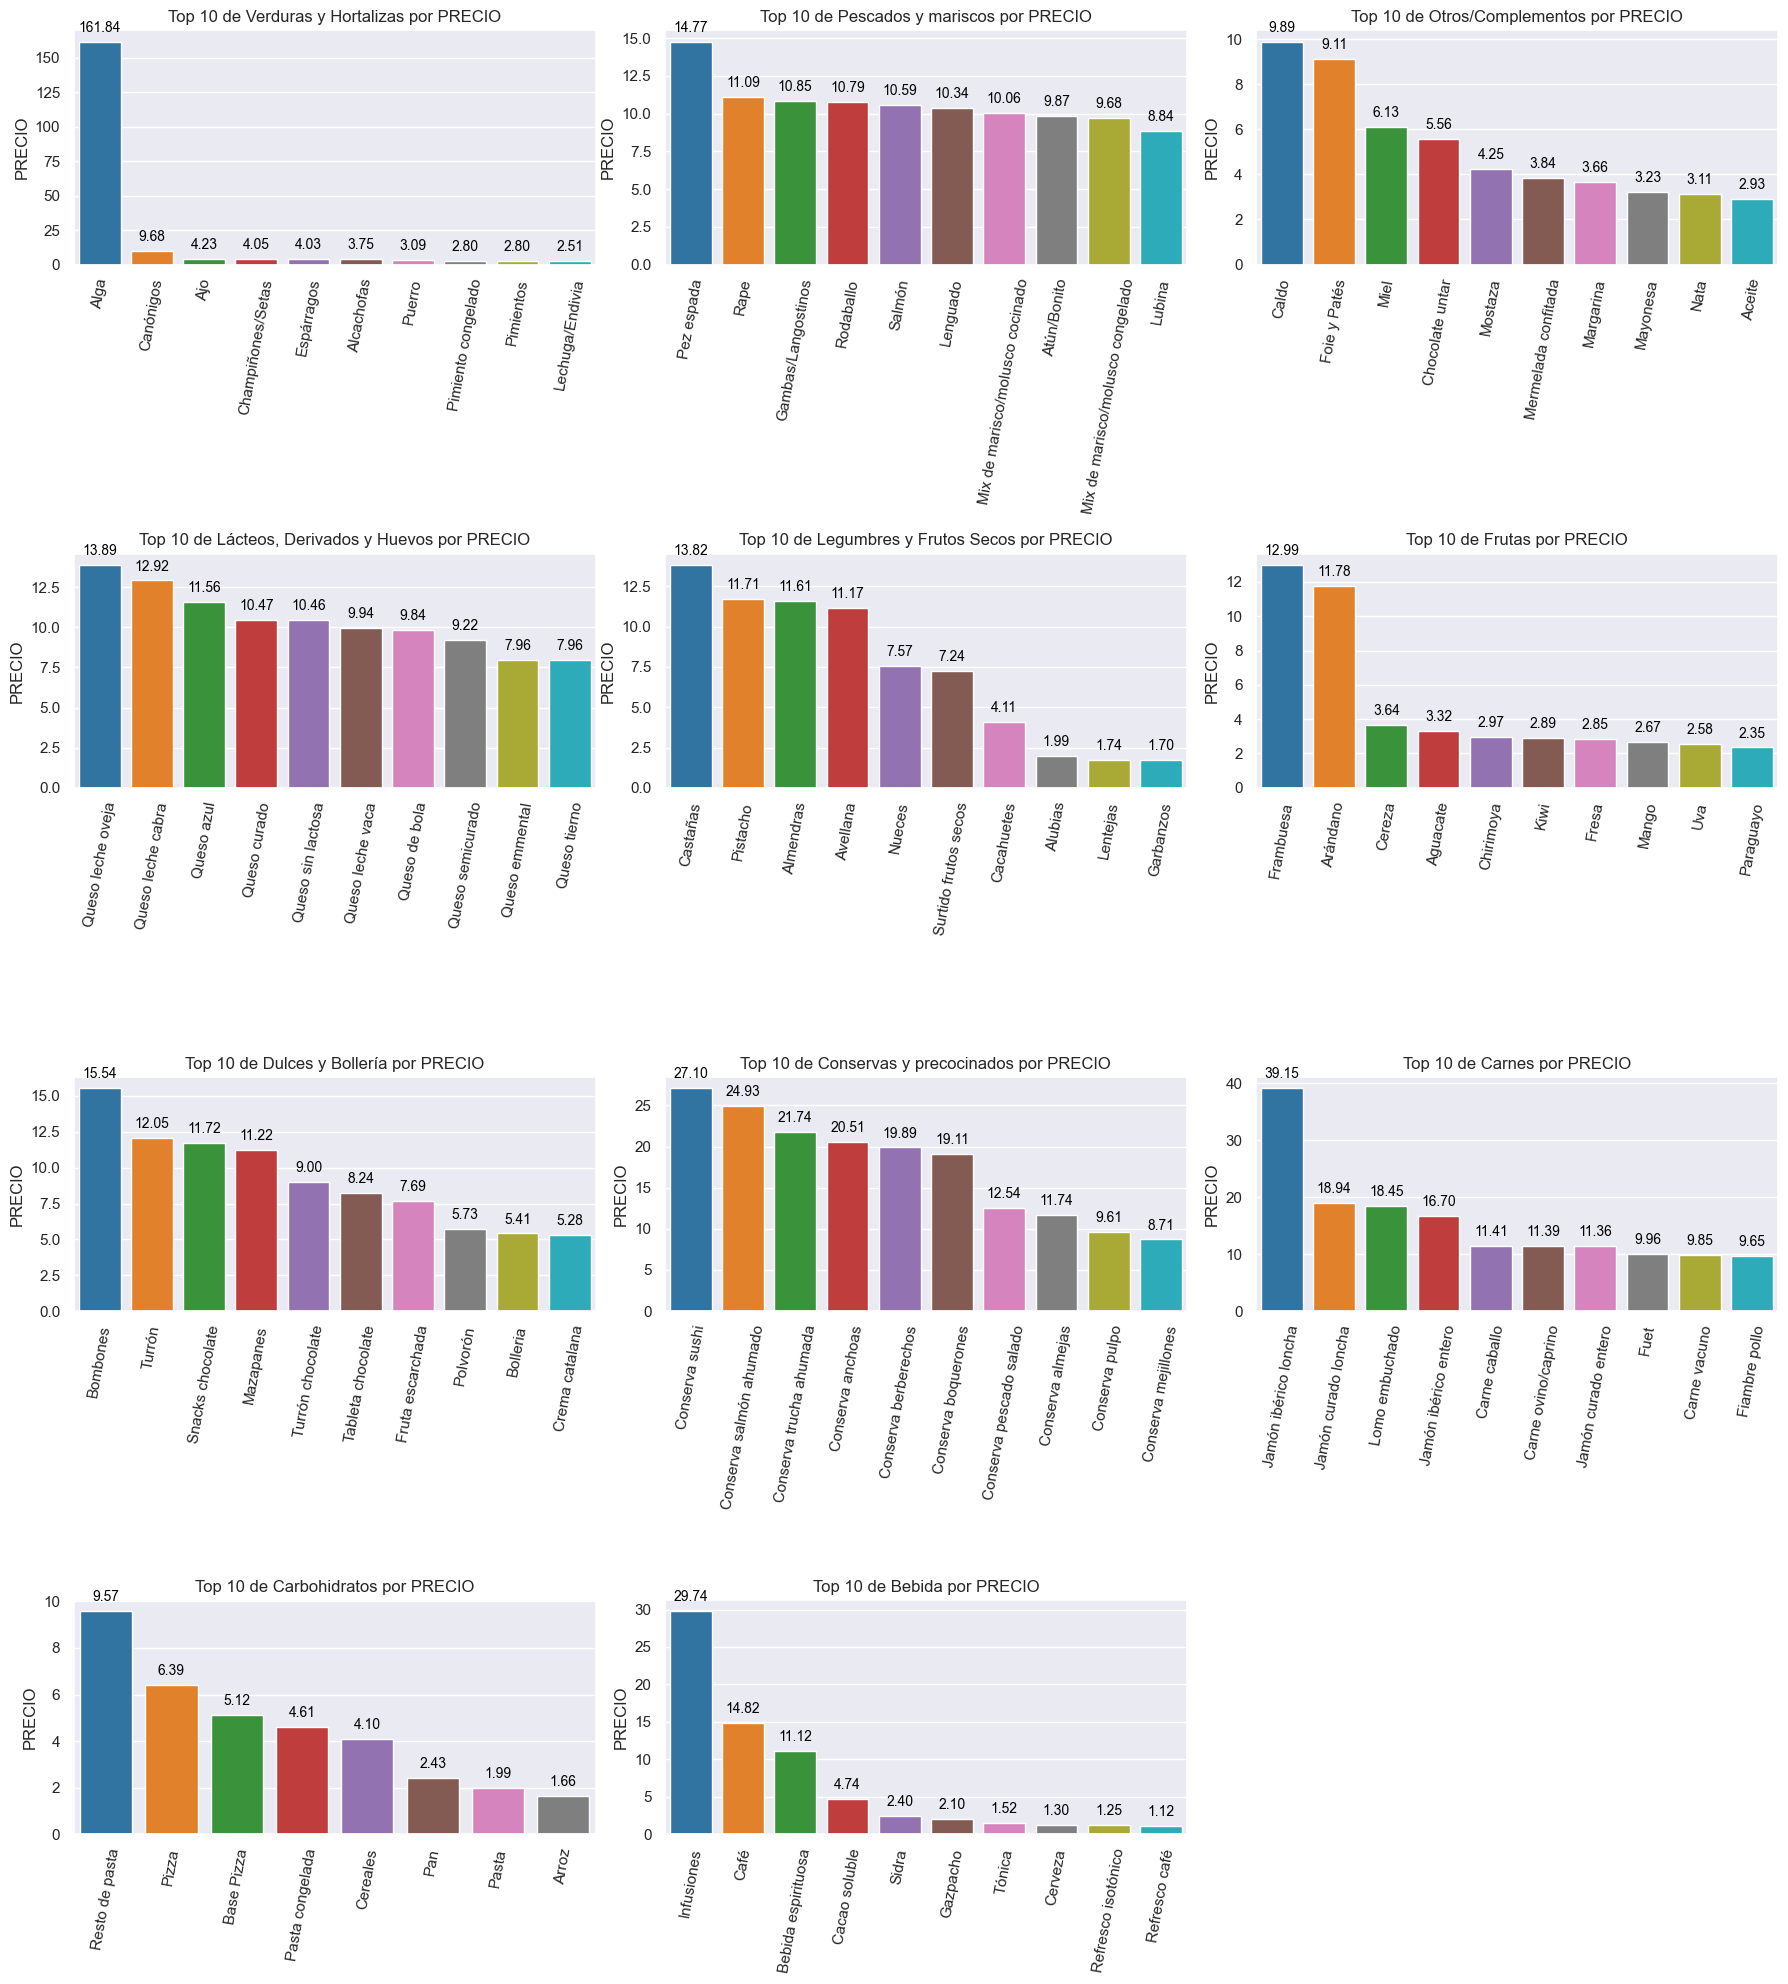

In [26]:
plot_top10('PENETRACIÓN')
plot_top10('CONSUMOXCÁPITA')
plot_top10('GASTOXCÁPITA')
plot_top10('PRECIO')

### 3.2) Top 10 alimentos con mayor crecimiento anual

En este apartado procedemos a analizar también los productos que más crecimiento anual han tenido a lo largo de los años. El dataset contiene datos desde el 2010.

In [27]:
#Primero tenemos que hacer pivot en el DataFrame para obtener el formato correcto para calcular el crecimiento porcentual anual

#Pivotamos
pivoted_spain_df = spain_df.pivot_table(index=['Categoría comida' , 'Nombre Refinado'], columns='dataset_year', values=['PENETRACIÓN','PRECIO','CONSUMOXCÁPITA','GASTOXCÁPITA'])
pivoted_spain_df

CONSUMOXCÁPITA                        \
dataset_year                                       2010       2011       2012   
Categoría comida      Nombre Refinado                                           
Bebida                Agua                    52.918334  51.484357  51.586723   
                      Bebida espirituosa            NaN        NaN        NaN   
                      Cacao soluble            1.246901   1.231952   1.204952   
                      Café                     1.670012   1.709934   1.747373   
                      Cerveza                 16.574741  17.114952  17.645661   
...                                                 ...        ...        ...   
Verduras y Hortalizas Pimientos                1.684914   1.779081   1.798656   
                      Puerro                        NaN        NaN        NaN   
                      Rábanos                       NaN        NaN        NaN   
                      Tomate                   9.625941  10.214267   9.978648   
                      Zanahorias               3.410732   3.449270   3.554690   

                                                                           \
dataset_year                                   2013       2014       2015   
Categoría comida      Nombre Refinado                                       
Bebida                Agua                52.030002  52.583143  56.464146   
                      Bebida espirituosa   0.000000   0.000000   0.726808   
                      Cacao soluble        1.275934   1.311156   1.357544   
                      Café                 1.803710   1.776159   1.730230   
                      Cerveza             17.803894  18.176185  18.313668   
...                                             ...        ...        ...   
Verduras y Hortalizas Pimientos            1.843435   1.827894   1.695653   
                      Puerro               0.000000   0.000000   0.000000   
                      Rábanos                   NaN        NaN        NaN   
                      Tomate              10.144117   9.791749   9.693700   
                      Zanahorias           3.639527   3.630203   3.416925   

                                                                           \
dataset_year                                   2016       2017       2018   
Categoría comida      Nombre Refinado                                       
Bebida                Agua                60.323092  61.373219  62.964332   
                      Bebida espirituosa   0.817508   0.741540   0.731032   
                      Cacao soluble        1.314252   1.213538   1.207987   
                      Café                 1.775427   1.698685   1.725361   
                      Cerveza             18.713479  18.503891  18.196952   
...                                             ...        ...        ...   
Verduras y Hortalizas Pimientos            1.771071   1.682734   1.773106   
                      Puerro               0.000000   0.000000   0.000000   
                      Rábanos                   NaN        NaN        NaN   
                      Tomate               9.840225   9.040444   9.254869   
                      Zanahorias           3.495871   3.244516   3.261782   

                                                     ...     PRECIO  \
dataset_year                                   2019  ...       2015   
Categoría comida      Nombre Refinado                ...              
Bebida                Agua                61.017904  ...   0.208597   
                      Bebida espirituosa   0.709038  ...  10.489279   
                      Cacao soluble        1.094962  ...   4.437272   
                      Café                 1.739047  ...  14.021726   
                      Cerveza             18.105728  ...   1.186006   
...                                             ...  ...        ...   
Verduras y Hortalizas Pimientos            1.737157  ...   2.645117   
                      Puerro          

In [28]:
def plot_top5_growth(metric):

    metric_base = pivoted_spain_df[metric][2010]
    metric_change_vs_base = (pivoted_spain_df[metric].divide(metric_base, axis=0) - 1) * 100
    metric_change_vs_base = metric_change_vs_base.round(2).reset_index()


    melted_df = pd.melt(
        metric_change_vs_base,
        id_vars=['Categoría comida', 'Nombre Refinado'],
        value_vars=metric_change_vs_base.columns[3:],
        var_name='dataset_year',
        value_name=metric
    )


    top5_crecimiento = (
        melted_df
        .groupby(['Categoría comida', 'Nombre Refinado'])[metric]
        .mean()
        .reset_index()
        .sort_values(by=metric, ascending=False)
        .groupby('Categoría comida')
        .head(5)
    )


    unique_categories = top5_crecimiento['Categoría comida'].unique()
    num_plots = len(unique_categories)
    fig, axs = plt.subplots(4, 3, figsize=(20, 15))
    axs = axs.flatten()  


    for i, grupo in enumerate(unique_categories):
        ax = axs[i]
        productos = top5_crecimiento[top5_crecimiento['Categoría comida'] == grupo]['Nombre Refinado']
        data_plot = melted_df[melted_df['Nombre Refinado'].isin(productos)]

        sns.lineplot(data=data_plot, x='dataset_year', y=metric, hue='Nombre Refinado', ax=ax)
        ax.set_title(f'{grupo}')
        ax.set_ylabel(metric)
        ax.set_xlabel('Año')
        ax.legend(loc='upper left', fontsize='small', bbox_to_anchor=(1.01, 1.02))

    for j in range(i+1, len(axs)):
        fig.delaxes(axs[j])

    fig.suptitle(f'Top 5 productos con mayor crecimiento por categoría ({metric})', fontsize=16)
    plt.tight_layout()
    plt.show()


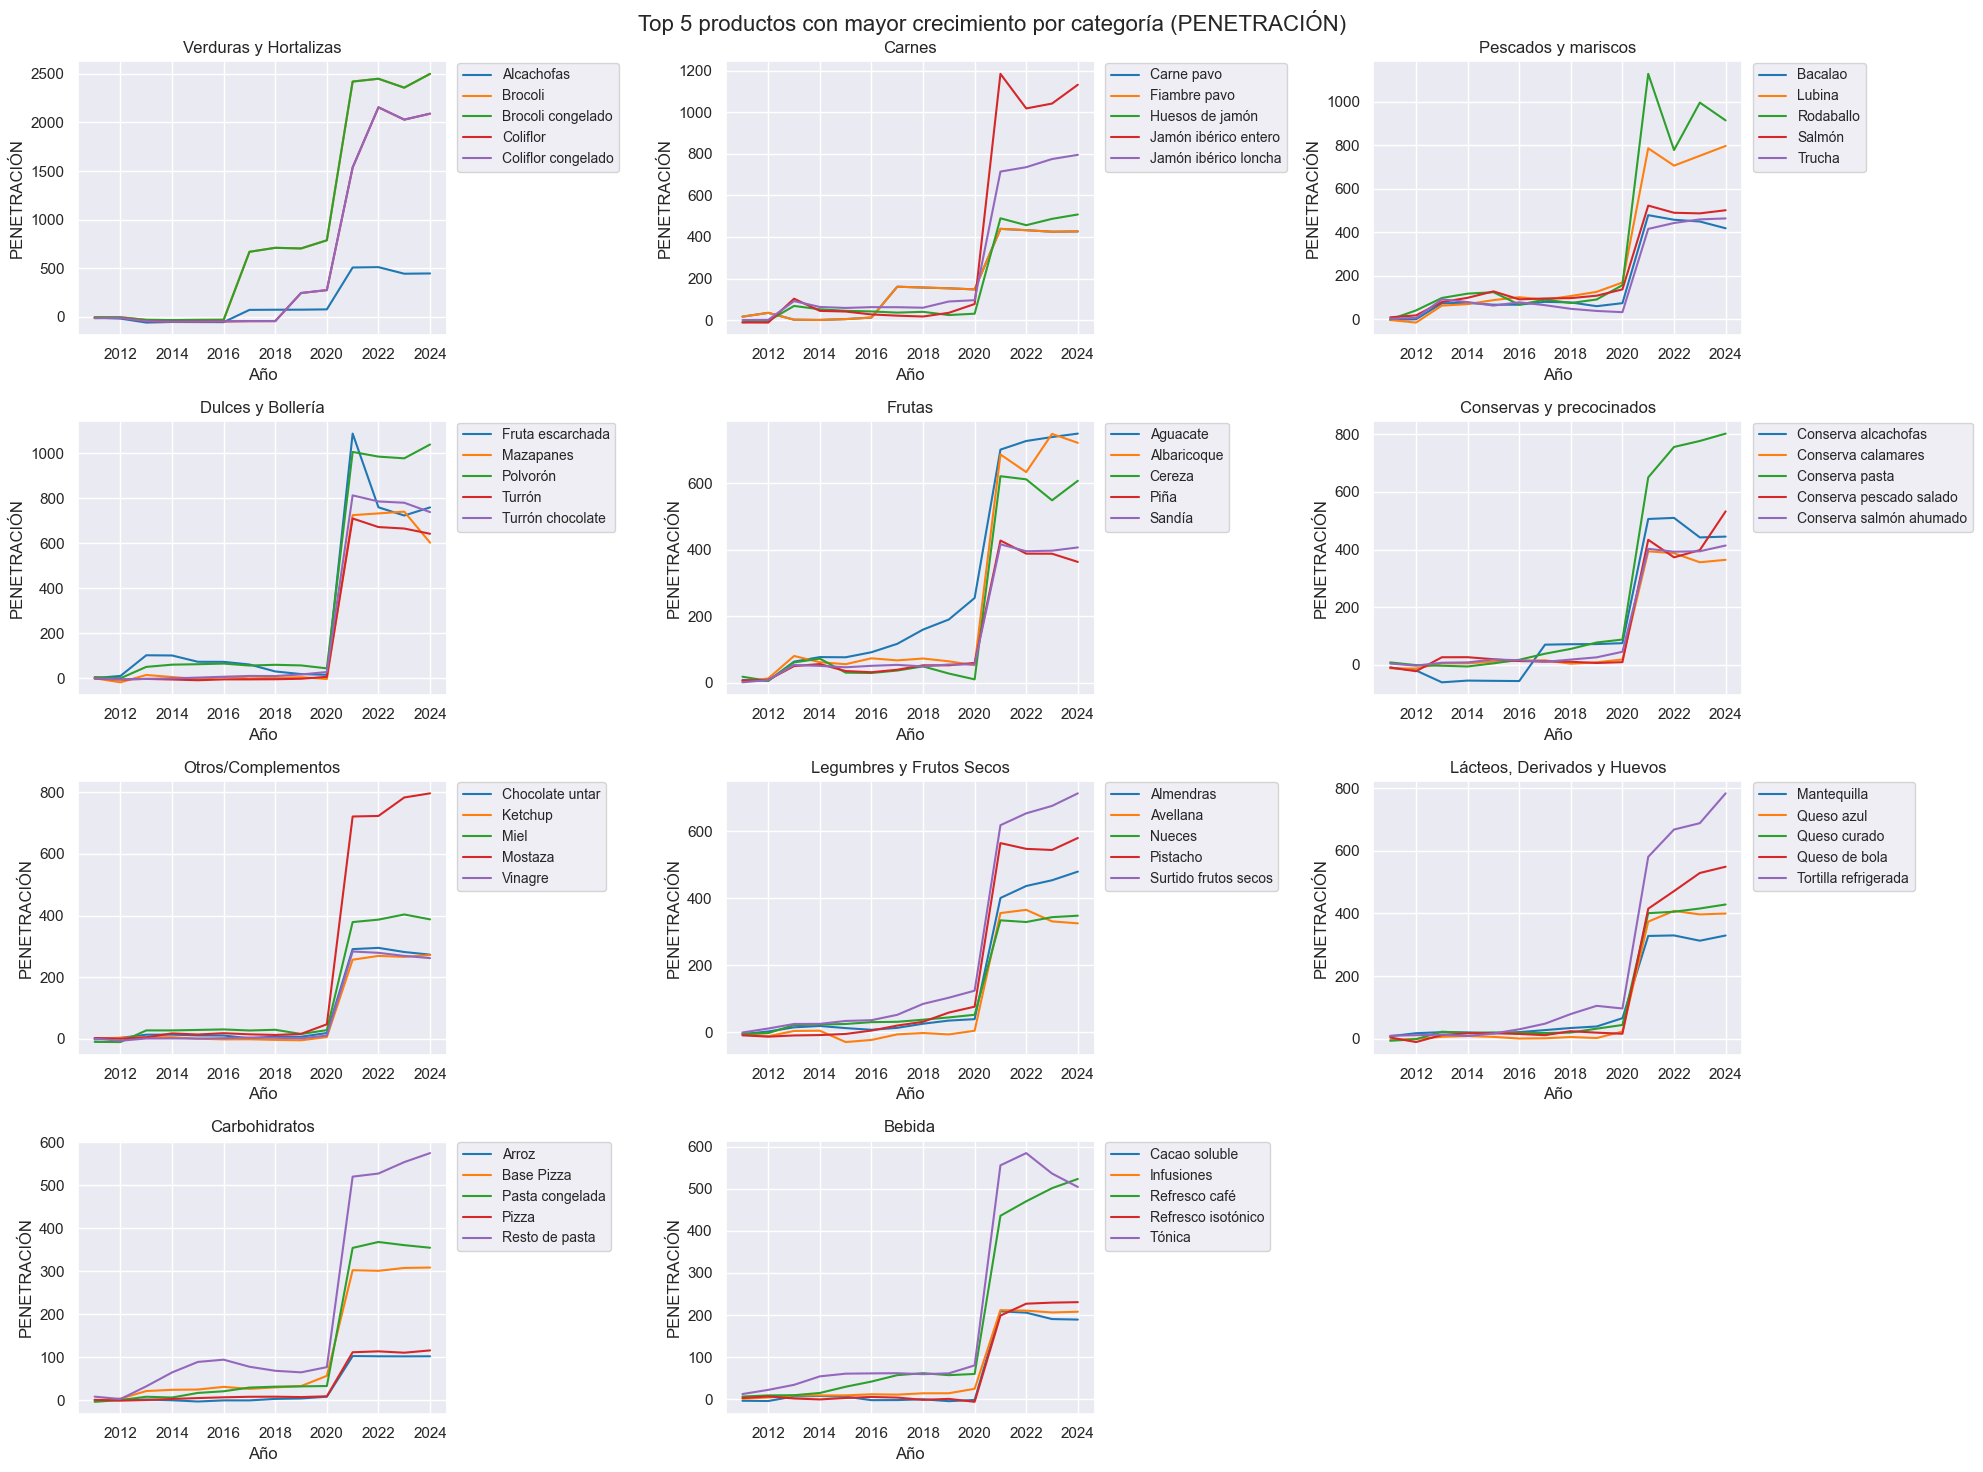

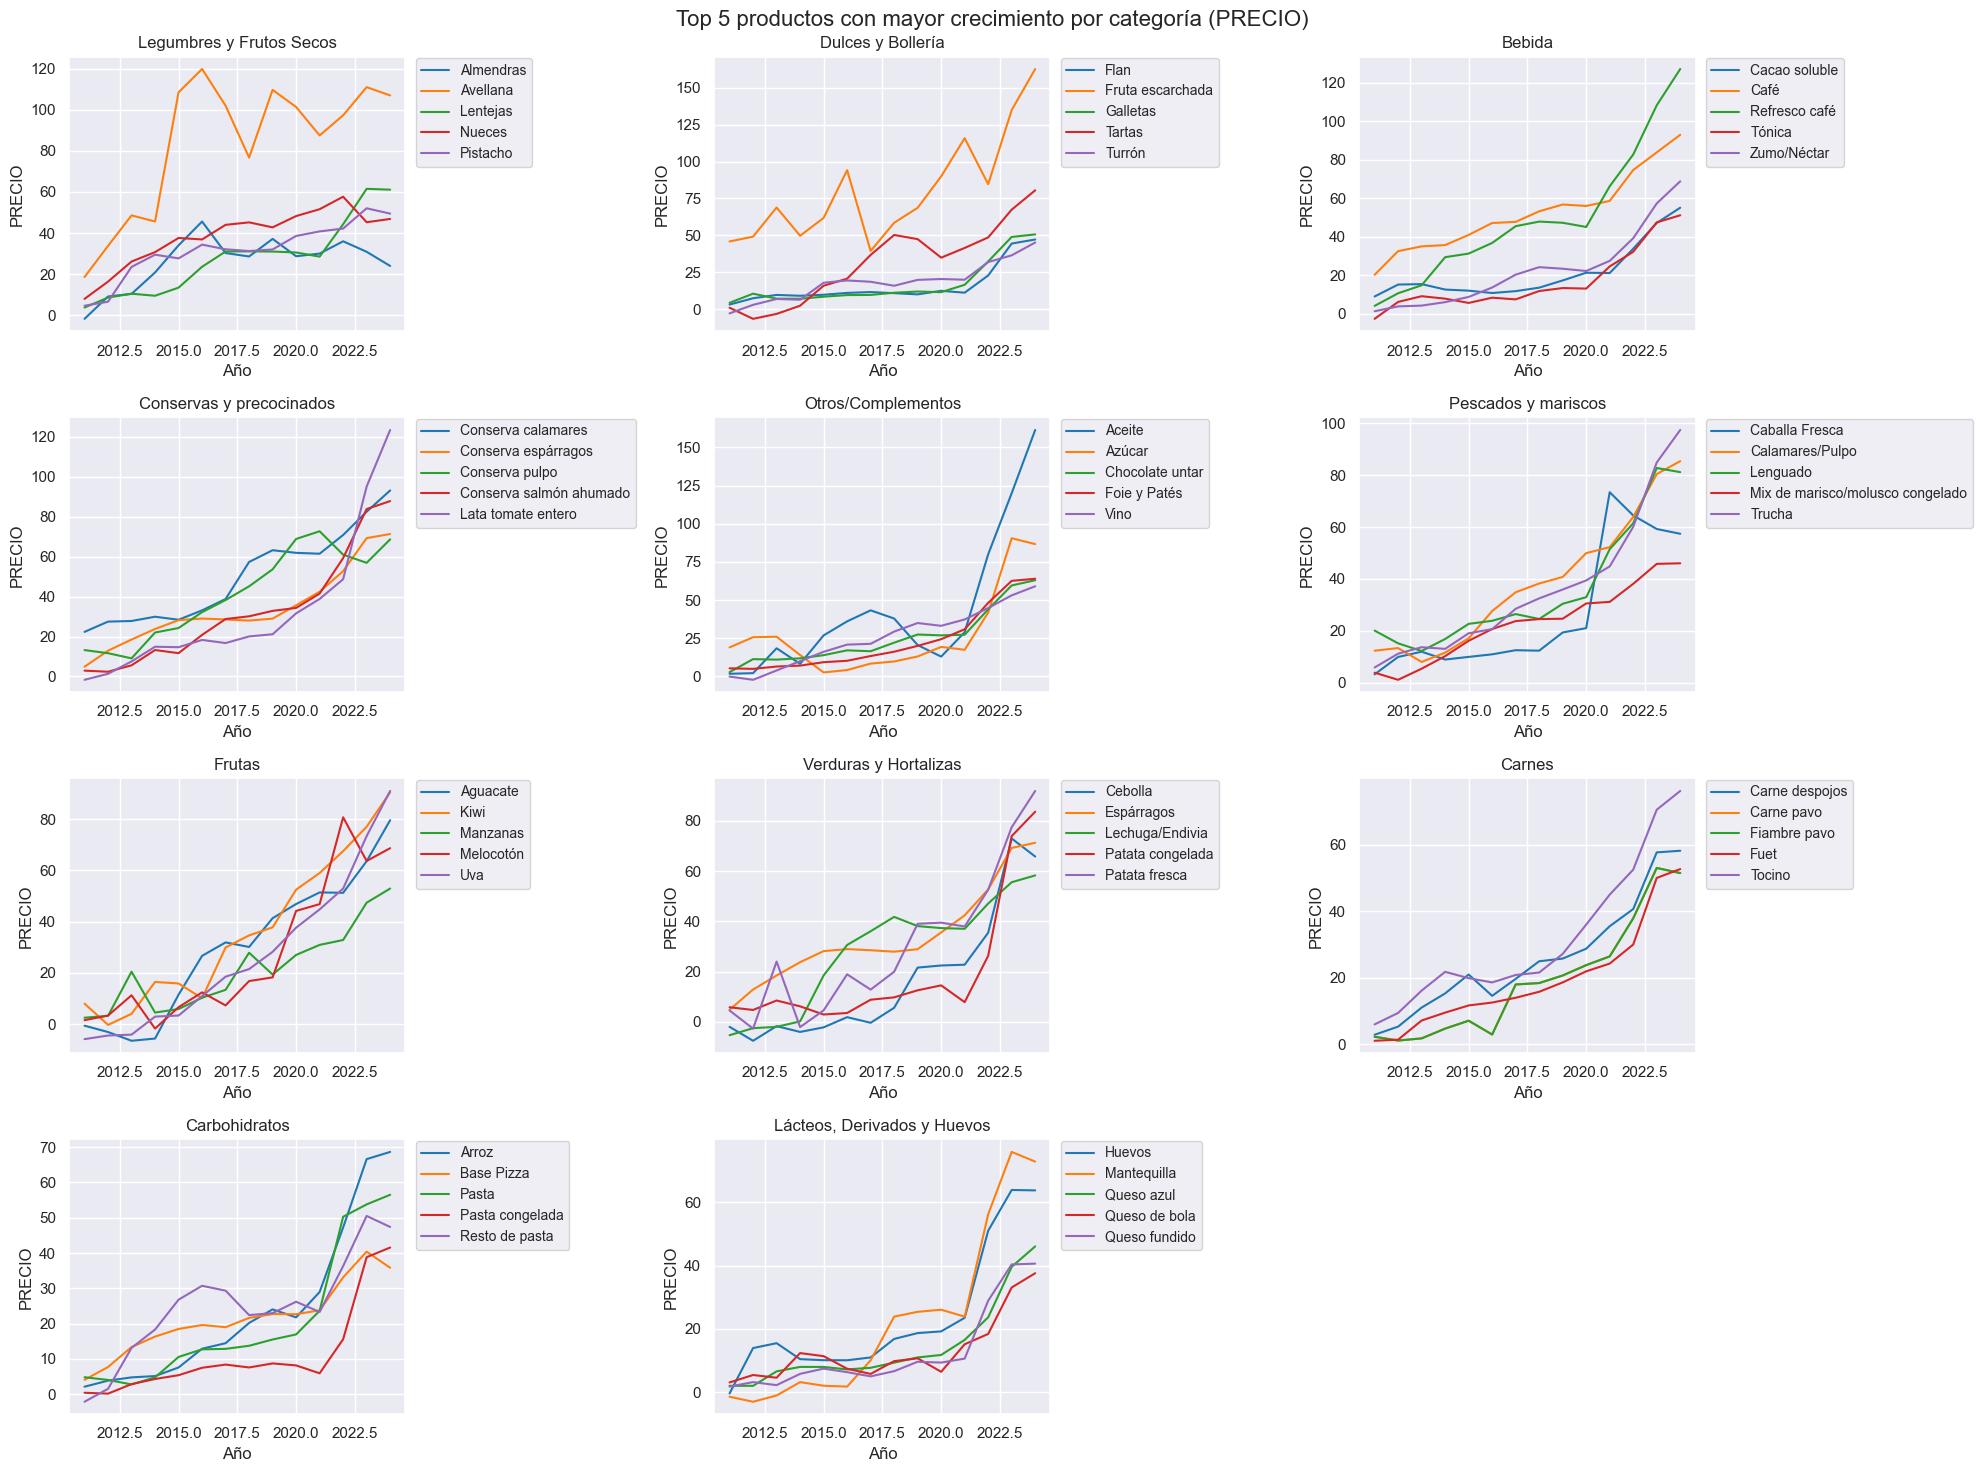

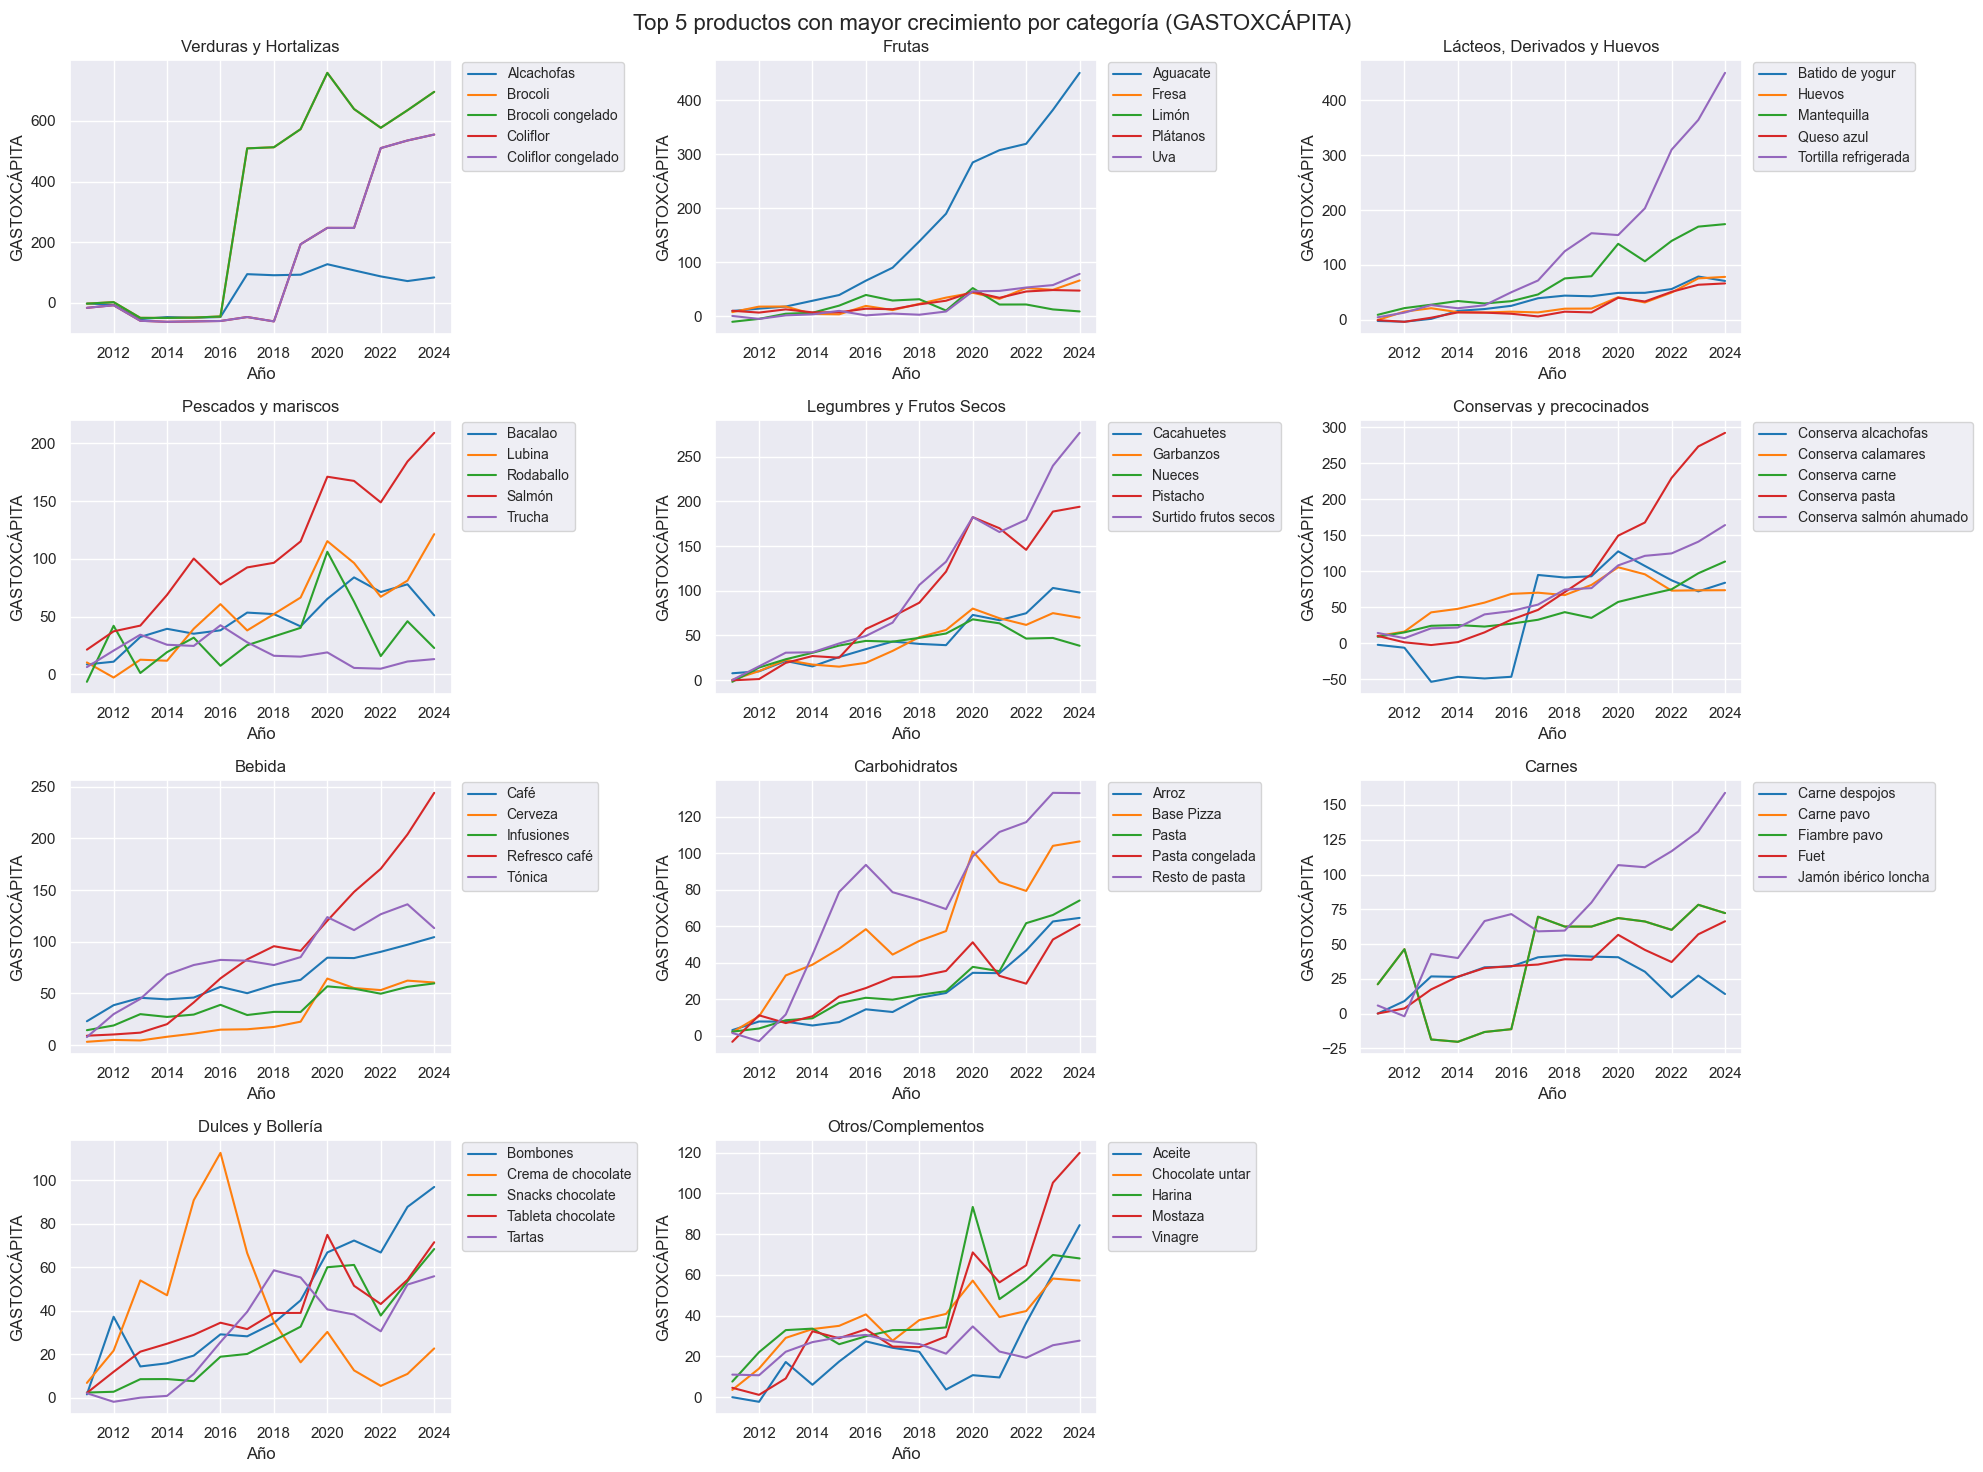

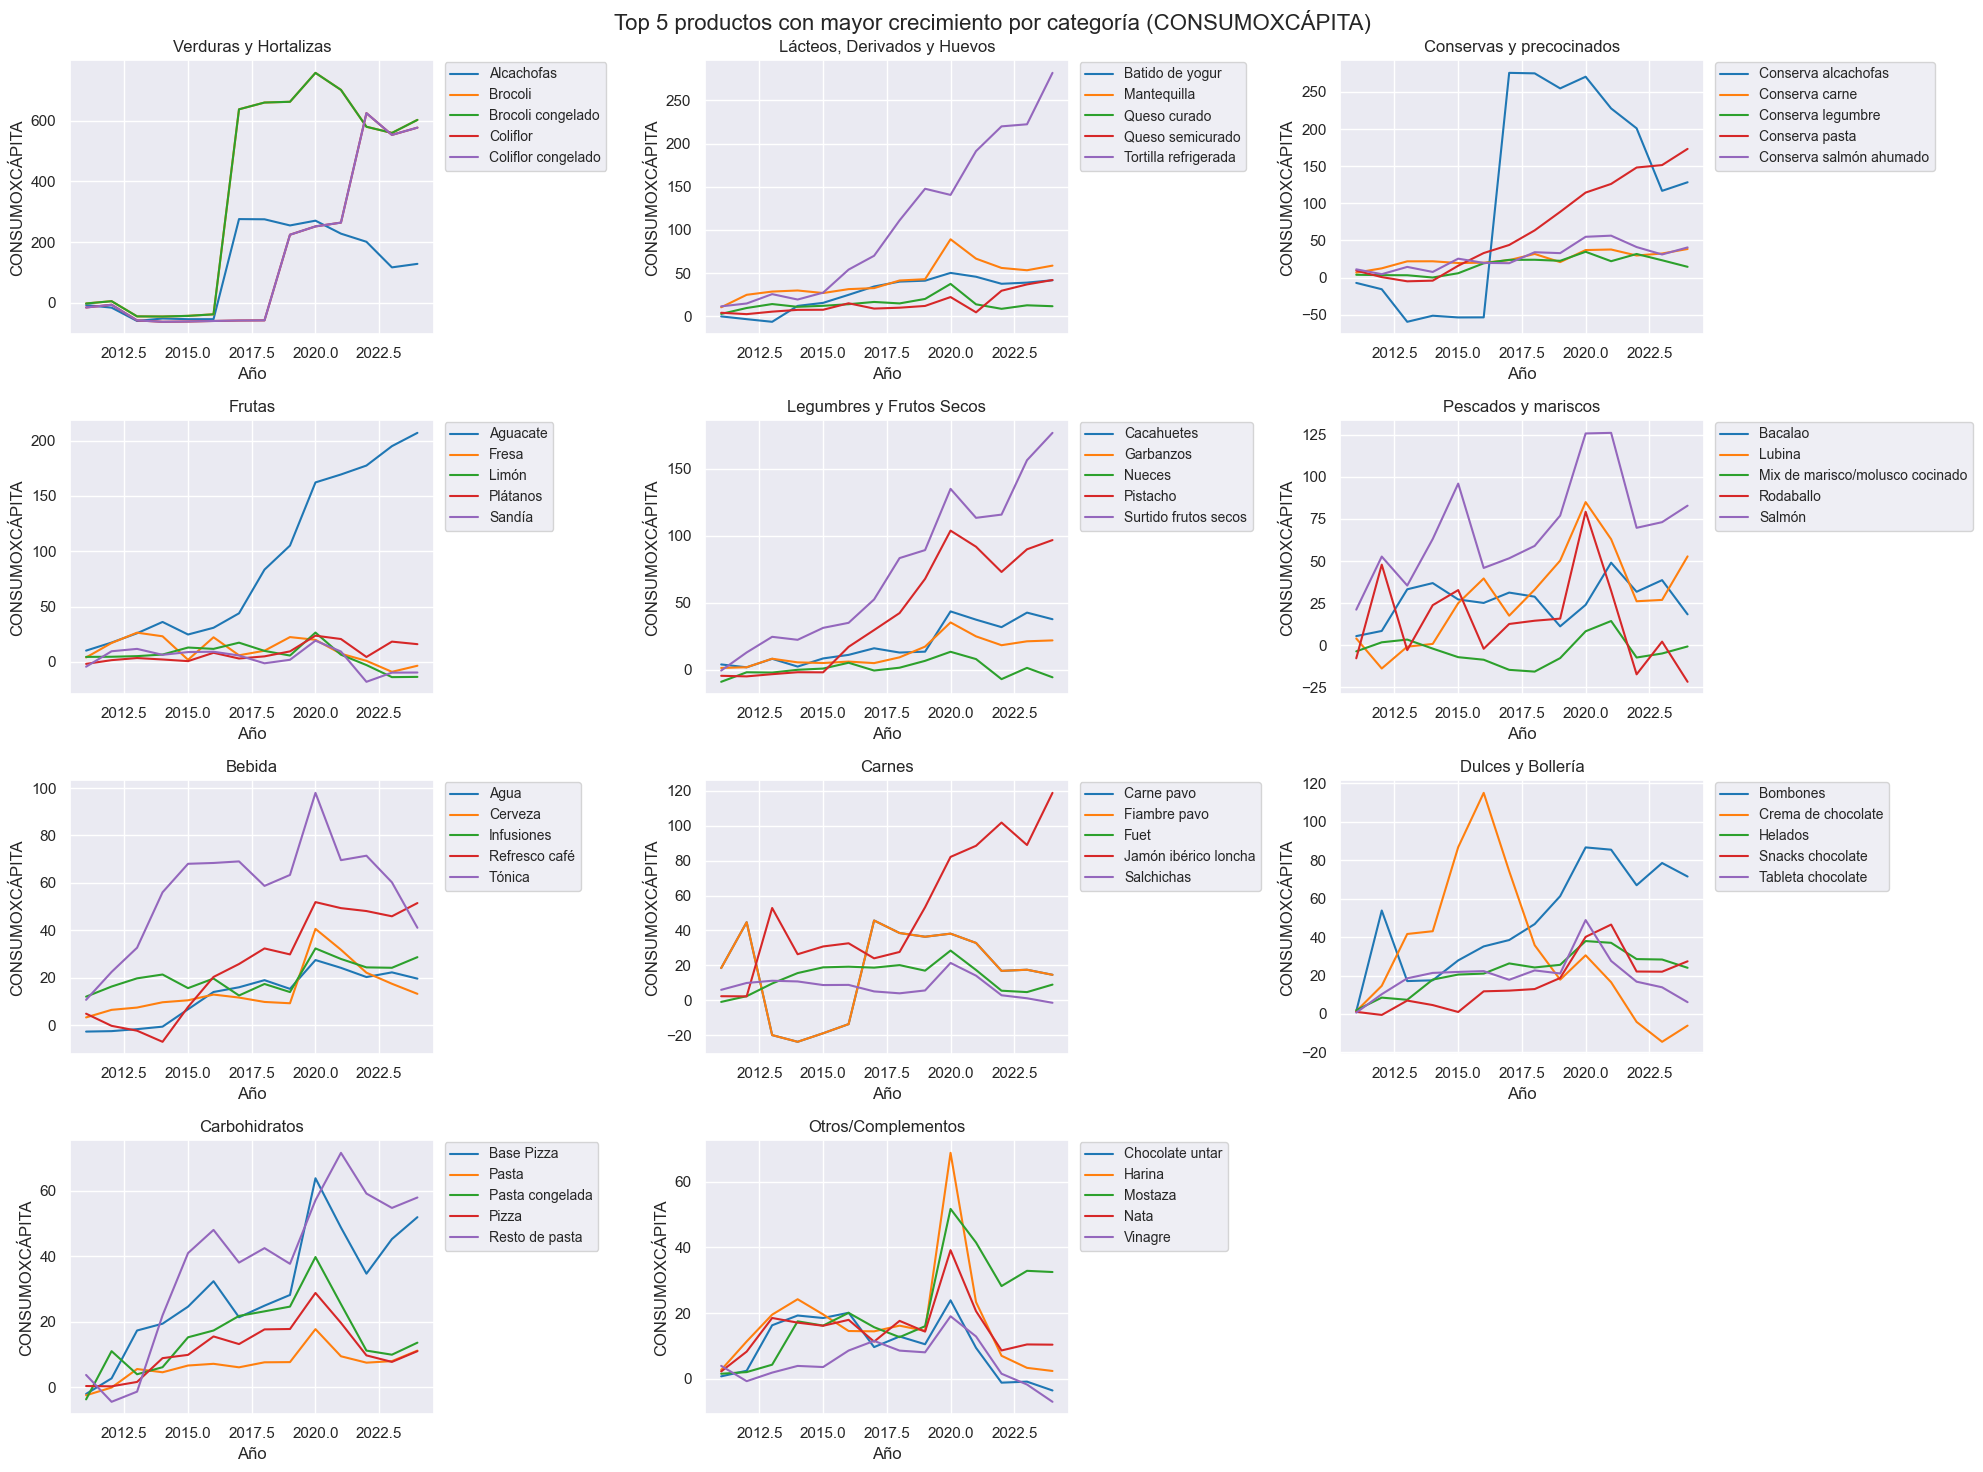

In [29]:
plot_top5_growth('PENETRACIÓN')
plot_top5_growth('PRECIO')
plot_top5_growth('GASTOXCÁPITA')
plot_top5_growth('CONSUMOXCÁPITA')

### 3.3) Decisión de clases a detectar en el futuro modelo

Se han decidido las clases sobre todo con los siguientes criterios:
- La penetración del producto ya que representa la cantidad porcentual de familias en España que han consumido este producto el año
- El ConsumoxCápita
- El crecimiento en comparación con 2010 para detectar productos que han tenido un crecimiento de penetración muy grande, lo que también indica que se están volviendo más populares.
- Criterio contextual: Solo escogeremos productos que típicamente son conservados en nevera, dado que el objetivo principal del máster es un modelo de detección de productos en la nevera. (En el futuro se podría hacer una ampliación para incluir también productos de despense)
- Criterio de transfer learning: Hay ciertos datasets para algunas clases de comida, en el caso de ser posible, se priorizarán productos de mayor consumo pero también los que tengan algún dataset de imágenes ya disponible.

In [30]:
spain_df['Categoría comida'].unique()

array(['Lácteos, Derivados y Huevos', 'Otros/Complementos', 'Carnes',
       'Pescados y mariscos', 'Conservas y precocinados',
       'Dulces y Bollería', 'Carbohidratos', 'Bebida',
       'Legumbres y Frutos Secos', 'Verduras y Hortalizas', 'Frutas'],
      dtype=object)

In [31]:
pivoted_spain_df.reset_index()

Categoría comida     Nombre Refinado CONSUMOXCÁPITA  \
dataset_year                                                      2010   
0                            Bebida                Agua      52.918334   
1                            Bebida  Bebida espirituosa            NaN   
2                            Bebida       Cacao soluble       1.246901   
3                            Bebida                Café       1.670012   
4                            Bebida             Cerveza      16.574741   
..                              ...                 ...            ...   
219           Verduras y Hortalizas           Pimientos       1.684914   
220           Verduras y Hortalizas              Puerro            NaN   
221           Verduras y Hortalizas             Rábanos            NaN   
222           Verduras y Hortalizas              Tomate       9.625941   
223           Verduras y Hortalizas          Zanahorias       3.410732   

                                                                     \
dataset_year       2011       2012       2013       2014       2015   
0             51.484357  51.586723  52.030002  52.583143  56.464146   
1                   NaN        NaN   0.000000   0.000000   0.726808   
2              1.231952   1.204952   1.275934   1.311156   1.357544   
3              1.709934   1.747373   1.803710   1.776159   1.730230   
4             17.114952  17.645661  17.803894  18.176185  18.313668   
..                  ...        ...        ...        ...        ...   
219            1.779081   1.798656   1.843435   1.827894   1.695653   
220                 NaN        NaN   0.000000   0.000000   0.000000   
221                 NaN        NaN        NaN        NaN        NaN   
222           10.214267   9.978648  10.144117   9.791749   9.693700   
223            3.449270   3.554690   3.639527   3.630203   3.416925   

                                    ...     PRECIO                        \
dataset_year       2016       2017  ...       2015       2016       2017   
0             60.323092  61.373219  ...   0.208597   0.210525   0.207830   
1              0.817508   0.741540  ...  10.489279  10.865181  10.657087   
2              1.314252   1.213538  ...   4.437272   4.389018   4.427611   
3              1.775427   1.698685  ...  14.021726  14.636843  14.694659   
4             18.713479  18.503891  ...   1.186006   1.200559   1.218046   
..                  ...        ...  ...        ...        ...        ...   
219            1.771071   1.682734  ...   2.645117   2.714528   2.716320   
220            0.000000   0.000000  ...        NaN        NaN        NaN   
221                 NaN        NaN  ...        NaN        NaN        NaN   
222            9.840225   9.040444  ...   1.394126   1.398889   1.470824   
223            3.495871   3.244516  ...   0.858414   0.846773   0.872601   

                                                                     \
dataset_year       2018       2019       2020       2021       2022   
0              0.208876   0.209220   0.203358   0.206228   0.211325   
1             10.647797  10.944379  10.979713  10.816056  11.533705   
2              4.499307   4.647547   4.806621   4.800363   5.300168   
3             15.240847  15.591888  15.517970  15.778594  17.374559   
4              1.263014   1.324167   1.378612   1.388471   1.479333   
..                  ...        ...        ...        ...        ...   
219            2.734920   2.802272   2.828712   2.855167   3.031503   
220                 NaN   2.695594   2.784883   2.946450   3.030775   
221                 NaN        NaN        NaN        NaN   2.377764   
222            1.485013   1.541549   1.590641   1.631821   1.875960   
223            0.906099   0.926570   0.956909   0.945099   1.034002   

                                    
dataset_year       2023       2024  
0              0.226906   0.232928  
1             12.313412  11.980091  
2              5.830092   6.144096  
3             18.285158  19.195224

In [32]:
grupos_a_considerar = [
    'Lácteos, Derivados y Huevos', 
    'Carnes',
    'Pescados y mariscos', 
    'Verduras y Hortalizas', 
    'Frutas'
]

## Paso 1. Obteniendo todos los dfs con los top 5 productos de cada categoría con mayor crecimiento de PENETRACIÓN y CONSUMOXCÁPITA
top5_crecimiento_dfs = {}

for metric in ['PENETRACIÓN', 'CONSUMOXCÁPITA']:

    penetration_base = pivoted_spain_df[metric][2010]
    penetration_change_vs_base = (pivoted_spain_df[metric].divide(penetration_base, axis=0) - 1) * 100
    penetration_change_vs_base = penetration_change_vs_base.round(2)

    penetration_change_vs_base = penetration_change_vs_base.reset_index()
    filtered_df = penetration_change_vs_base[penetration_change_vs_base['Categoría comida'].isin(grupos_a_considerar)]

    melted_df = pd.melt(
        filtered_df,
        id_vars=['Categoría comida', 'Nombre Refinado'],
        value_vars=filtered_df.columns[3:],  
        var_name='dataset_year',
        value_name=metric
    )

    top5_crecimiento = (
        melted_df
        .groupby(['Categoría comida', 'Nombre Refinado'])[metric]
        .mean()
        .reset_index()
        .sort_values(by=metric, ascending=False)
        .groupby('Categoría comida')
        .head(5)
    )

    top5_crecimiento_dfs[metric] = top5_crecimiento

top5_crecimiento_penetración = top5_crecimiento_dfs['PENETRACIÓN']
top5_crecimiento_penetración['rank'] = top5_crecimiento_penetración.groupby('Categoría comida')['PENETRACIÓN'].rank(ascending=False, method='first')
top5_crecimiento_penetración['Top 5 Penetración crecimiento'] = top5_crecimiento_penetración['Nombre Refinado']

top5_crecimiento_consumoxcapita = top5_crecimiento_dfs['CONSUMOXCÁPITA']
top5_crecimiento_consumoxcapita['rank'] = top5_crecimiento_consumoxcapita.groupby('Categoría comida')['CONSUMOXCÁPITA'].rank(ascending=False, method='first')
top5_crecimiento_consumoxcapita['Top 5 ConsumoXCápita crecimiento'] = top5_crecimiento_consumoxcapita['Nombre Refinado']


## Paso 2. Obteniendo todos los dfs con los top 10 productos de cada categoría con mayor PENETRACIÓN y CONSUMOXCÁPITA

top10_penetracion = spain_df.groupby(['Categoría comida', 'Nombre Refinado'])["PENETRACIÓN"].mean().reset_index().sort_values(by="PENETRACIÓN", ascending=False).groupby('Categoría comida').head(10).sort_values(by=['Categoría comida', "PENETRACIÓN"], ascending=False)
top10_penetracion['rank'] = top10_penetracion.groupby('Categoría comida')['PENETRACIÓN'].rank(ascending=False, method='first')
top10_penetracion['Top 10 Penetración'] = top10_penetracion['Nombre Refinado']

top10_consumoxcapita = spain_df.groupby(['Categoría comida', 'Nombre Refinado'])["CONSUMOXCÁPITA"].mean().reset_index().sort_values(by="CONSUMOXCÁPITA", ascending=False).groupby('Categoría comida').head(10).sort_values(by=['Categoría comida', "CONSUMOXCÁPITA"], ascending=False)
top10_consumoxcapita['rank'] = top10_consumoxcapita.groupby('Categoría comida')['CONSUMOXCÁPITA'].rank(ascending=False, method='first')
top10_consumoxcapita['Top 10 ConsumoXCápita'] = top10_consumoxcapita['Nombre Refinado']

## Paso 3. Hago merge de todos los dfs para tener una tabla resumen final
merge_1 = pd.merge(top5_crecimiento_penetración, top5_crecimiento_consumoxcapita, on=['Categoría comida','rank'], how='inner')
merge_2 = pd.merge(top10_penetracion, top10_consumoxcapita, on=['Categoría comida','rank'], how='inner')
merge_top_productos_final = pd.merge(merge_2, merge_1, on=['Categoría comida','rank'], how='left')

## Paso 4. Selecciono solamente las columnas necesarias

top_productos_final_tratado = merge_top_productos_final[['Categoría comida', 'Top 10 Penetración', 'Top 10 ConsumoXCápita', 'Top 5 Penetración crecimiento', 'Top 5 ConsumoXCápita crecimiento']]

In [33]:
#Productos de verdura y hortalizas
top_productos_final_tratado[top_productos_final_tratado['Categoría comida'] == "Verduras y Hortalizas"]

Categoría comida Top 10 Penetración Top 10 ConsumoXCápita  \
0  Verduras y Hortalizas             Tomate         Patata fresca   
1  Verduras y Hortalizas            Cebolla                Tomate   
2  Verduras y Hortalizas      Patata fresca               Cebolla   
3  Verduras y Hortalizas    Lechuga/Endivia       Lechuga/Endivia   
4  Verduras y Hortalizas         Zanahorias           Calabacines   
5  Verduras y Hortalizas           Calabaza            Zanahorias   
6  Verduras y Hortalizas        Calabacines                Pepino   
7  Verduras y Hortalizas                Ajo             Pimientos   
8  Verduras y Hortalizas  Champiñones/Setas    Pimiento congelado   
9  Verduras y Hortalizas             Pepino            Berenjenas   

  Top 5 Penetración crecimiento Top 5 ConsumoXCápita crecimiento  
0             Brocoli congelado                Brocoli congelado  
1                       Brocoli                          Brocoli  
2                      Coliflor                         Coliflor  
3            Coliflor congelado               Coliflor congelado  
4                    Alcachofas                       Alcachofas  
5                           NaN                              NaN  
6                           NaN                              NaN  
7                           NaN                              NaN  
8                           NaN                              NaN  
9                           NaN                              NaN

De verduras escogeremos 10.
Hay overlap de casi todos los productos en top 10 penetración y top 10 consumoxcápita, menos:
- Ajo
- Calabaza
- Champiñones

De aquí tomamos 8 clases: [Tomate, Cebolla, Patata fresca, Lechuga/Endivia, Zanahorias, Calabacines, Pepino, Champiñones] (a pesar de que Champiñones no ha tenido solapamiento, se dispone de un dataset de imágenes de champiñones)


Mientras tanto vemos que Top 5 crecimiento de penetración y consumoxcápita coinciden al 100%. Cogemos Coliflor y Brocoli ya que son las dos clases con más crecimiento (ignoramos los productos congelados.)

In [34]:
#Productos de Lácteos, Derivados y Huevos
top_productos_final_tratado[top_productos_final_tratado['Categoría comida'] == 'Lácteos, Derivados y Huevos']

Categoría comida Top 10 Penetración Top 10 ConsumoXCápita  \
30  Lácteos, Derivados y Huevos     Leche envasada                Huevos   
31  Lácteos, Derivados y Huevos             Huevos        Leche envasada   
32  Lácteos, Derivados y Huevos              Yogur                 Yogur   
33  Lácteos, Derivados y Huevos   Queso leche vaca       Batido de leche   
34  Lácteos, Derivados y Huevos       Queso fresco          Queso fresco   
35  Lácteos, Derivados y Huevos  Queso leche cabra      Queso semicurado   
36  Lácteos, Derivados y Huevos  Queso leche oveja       Batido de yogur   
37  Lácteos, Derivados y Huevos   Queso semicurado         Queso fundido   
38  Lácteos, Derivados y Huevos      Queso fundido      Queso leche vaca   
39  Lácteos, Derivados y Huevos       Queso tierno     Queso leche cabra   

   Top 5 Penetración crecimiento Top 5 ConsumoXCápita crecimiento  
30          Tortilla refrigerada             Tortilla refrigerada  
31                 Queso de bola                      Mantequilla  
32                  Queso curado                  Batido de yogur  
33                    Queso azul                 Queso semicurado  
34                   Mantequilla                     Queso curado  
35                           NaN                              NaN  
36                           NaN                              NaN  
37                           NaN                              NaN  
38                           NaN                              NaN  
39                           NaN                              NaN

De Lácteos, Derivados y Huevos escogeremos 6.
Hay overlap de casi todos los productos en top 10 penetración y top 10 consumoxcápita, menos:
- Queso leche oveja
- Queso tierno

De aquí tomamos 5 clases: [Leche envasada, Huevos, Yogur, Queso (simplicado de Quesos Lonchas, Queso Fresco)] (se simplifican los diferentes quesos como queso para simplificar)

Mientras tanto vemos que Top 5 crecimiento de penetración y consumoxcápita coinciden tortilla refrigerada, queso curado y mantequilla. Queso curado se consideraría como queso loncha. Se escoge mantequilla como clase extra a predecir dado que está disponible en un dataset público y adicionalmente es un ingrediente muy común en muchas recetas.

In [35]:
#Productos de Carnes
top_productos_final_tratado[top_productos_final_tratado['Categoría comida'] == 'Carnes']

Categoría comida   Top 10 Penetración Top 10 ConsumoXCápita  \
80           Carnes          Carne pollo           Carne pollo   
81           Carnes          Carne cerdo           Carne cerdo   
82           Carnes         Carne vacuno          Carne vacuno   
83           Carnes  Jamón curado loncha   Carne ovino/caprino   
84           Carnes         Jamón Cocido            Salchichas   
85           Carnes              Chorizo       Carne congelada   
86           Carnes           Salchichas          Jamón Cocido   
87           Carnes           Carne pavo            Carne pavo   
88           Carnes         Fiambre pavo          Fiambre pavo   
89           Carnes                 Fuet   Jamón curado loncha   

   Top 5 Penetración crecimiento Top 5 ConsumoXCápita crecimiento  
80          Jamón ibérico entero             Jamón ibérico loncha  
81          Jamón ibérico loncha                       Carne pavo  
82                  Fiambre pavo                     Fiambre pavo  
83                    Carne pavo                             Fuet  
84               Huesos de jamón                       Salchichas  
85                           NaN                              NaN  
86                           NaN                              NaN  
87                           NaN                              NaN  
88                           NaN                              NaN  
89                           NaN                              NaN

De esta categoría escogeremos las siguientes 5 clases:
["Carne pollo", "Carne cerdo", "Carne vacuno", "Salchichas", "Carne pavo"]

Esto es debido a que estas 5 categorías aparecen en múltiples columnas -->

In [36]:
#Productos de Pescados y mariscos
top_productos_final_tratado[top_productos_final_tratado['Categoría comida'] == 'Pescados y mariscos']

Categoría comida                Top 10 Penetración  \
10  Pescados y mariscos                           Merluza   
11  Pescados y mariscos                Gambas/Langostinos   
12  Pescados y mariscos     Mix de marisco/molusco fresco   
13  Pescados y mariscos  Mix de marisco/molusco congelado   
14  Pescados y mariscos                   Calamares/Pulpo   
15  Pescados y mariscos                  Sardina/Boquerón   
16  Pescados y mariscos                            Salmón   
17  Pescados y mariscos                           Bacalao   
18  Pescados y mariscos   Mix de marisco/molusco cocinado   
19  Pescados y mariscos                        Mejillones   

               Top 10 ConsumoXCápita Top 5 Penetración crecimiento  \
10     Mix de marisco/molusco fresco                     Rodaballo   
11                           Merluza                        Lubina   
12  Mix de marisco/molusco congelado                        Salmón   
13                Gambas/Langostinos                       Bacalao   
14                  Sardina/Boquerón                        Trucha   
15                   Calamares/Pulpo                           NaN   
16                            Salmón                           NaN   
17                        Mejillones                           NaN   
18                           Bacalao                           NaN   
19   Mix de marisco/molusco cocinado                           NaN   

   Top 5 ConsumoXCápita crecimiento  
10                           Salmón  
11                           Lubina  
12                          Bacalao  
13                        Rodaballo  
14  Mix de marisco/molusco cocinado  
15                              NaN  
16                              NaN  
17                              NaN  
18                              NaN  
19                              NaN

De esta categoría escogeremos las siguientes 5 clases:
["Merluza", "Gambas/Langostinos", "Mix de marisco/molusco", "Lubina", "Salmón"]

Se ha decidido que sería bastante difícil para el modelo diferenciar entre mix de marisco/molusco congelado y fresco, por lo que se ha unificado. Después se han cogido categorías que fueran repetidas al menos en dos columnas.

In [37]:
#Productos de Frutas
top_productos_final_tratado[top_productos_final_tratado['Categoría comida'] == 'Frutas']

Categoría comida Top 10 Penetración Top 10 ConsumoXCápita  \
50           Frutas           Plátanos               Naranja   
51           Frutas           Manzanas              Plátanos   
52           Frutas          Paraguayo              Manzanas   
53           Frutas            Naranja                Sandía   
54           Frutas              Peras                 Melón   
55           Frutas          Mandarina             Mandarina   
56           Frutas              Limón                 Peras   
57           Frutas               Kiwi             Melocotón   
58           Frutas              Caqui                  Kiwi   
59           Frutas              Fresa                 Fresa   

   Top 5 Penetración crecimiento Top 5 ConsumoXCápita crecimiento  
50                      Aguacate                         Aguacate  
51                   Albaricoque                            Fresa  
52                        Cereza                         Plátanos  
53                        Sandía                            Limón  
54                          Piña                           Sandía  
55                           NaN                              NaN  
56                           NaN                              NaN  
57                           NaN                              NaN  
58                           NaN                              NaN  
59                           NaN                              NaN

De esta categoría escogeremos las siguientes 5 clases:
- ["Plátano", "Sandía"] Estas clases aparecen en 3 columnas diferentes y son top 5.
- ["Limón", "Manzanas", "Aguacate"] Estas clases aparecen en 2 columnas diferentes

In [38]:
clases_escogidas = [
    "Tomate", "Cebolla", "Patata fresca", "Lechuga/Endivia", "Zanahoria",
    "Calabacines", "Pepino", "Champiñones", "Brocoli", "Coliflor",
    "Leche envasada", "Huevos", "Yogur", "Queso", "Mantequilla",
    "Merluza", "Gambas/Langostinos", "Mix de marisco/molusco", "Lubina", "Salmón",
    "Plátano", "Aguacate", "Sandía", "Limón", "Manzana", "Carne pollo", "Carne cerdo", "Carne vacuno", "Salchichas", "Carne pavo"
]

### 3.4) Datos socioeconómicos sobre las clases a utilizar

In [39]:
# Definiendo los grupos de variables socioeconómicas:
clase_social = ['NIVEL BAJO', 'NIVEL MEDIO-BAJO', 'NIVEL MEDIO','NIVEL MEDIO-ALTO', 'NIVEL ALTO']
edad_del_responsable_de_compra = ['- 35 AÑOS', '35 A 49 AÑOS', '50 A 64 AÑOS', '65 Y MAS AÑOS']
tamaño_hogar = ['1 PERSONA', '2 PERSONAS', '3 PERSONAS', '4 PERSONAS','4 Y MAS PERSONAS']
tipo_hogar = ['JOVENES INDEPENDIENTES', 'PAREJ.JOVENES SIN HIJOS',
       'PAREJ.CON HIJOS PEQUEÑOS', 'PAREJ.CON HIJOS EDAD MEDIA',
       'PAREJ.CON HIJOS MAYORES', 'HOGARES MONOPARENTALES',
       'PAREJAS ADULTAS SIN HIJOS', 'ADULTOS INDEPENDIENTES', 'RETIRADOS']
lista_de_listas_socioeconómicos = [clase_social, edad_del_responsable_de_compra, tamaño_hogar, tipo_hogar]

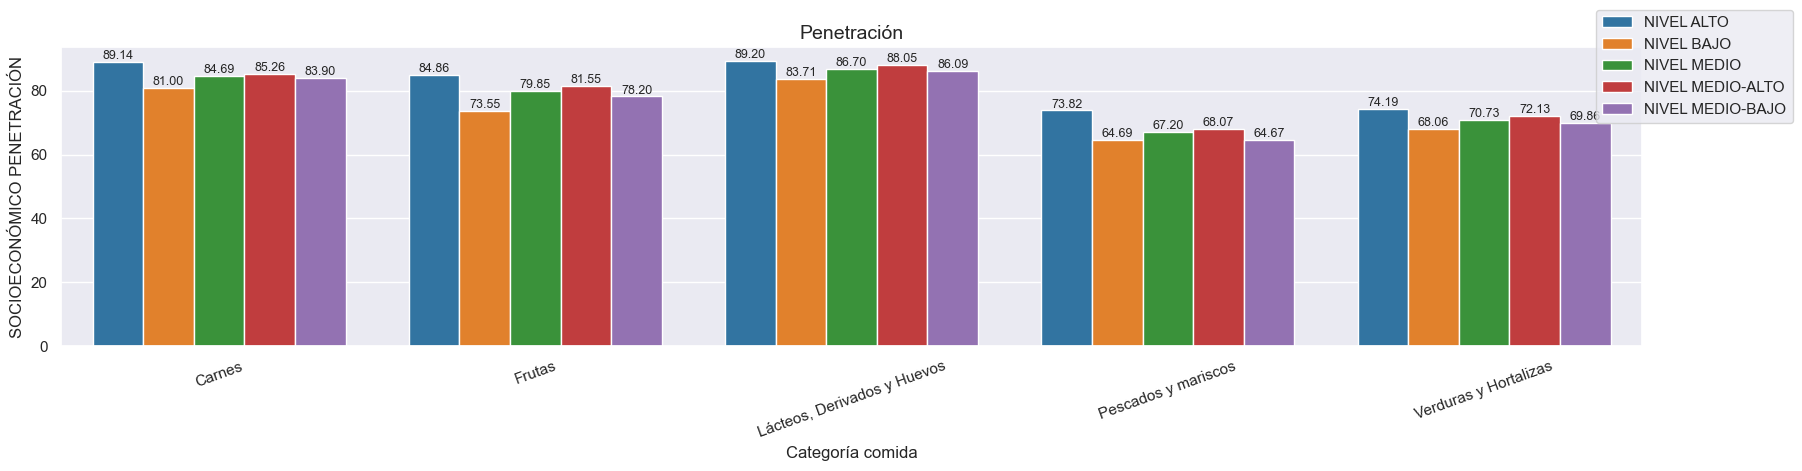

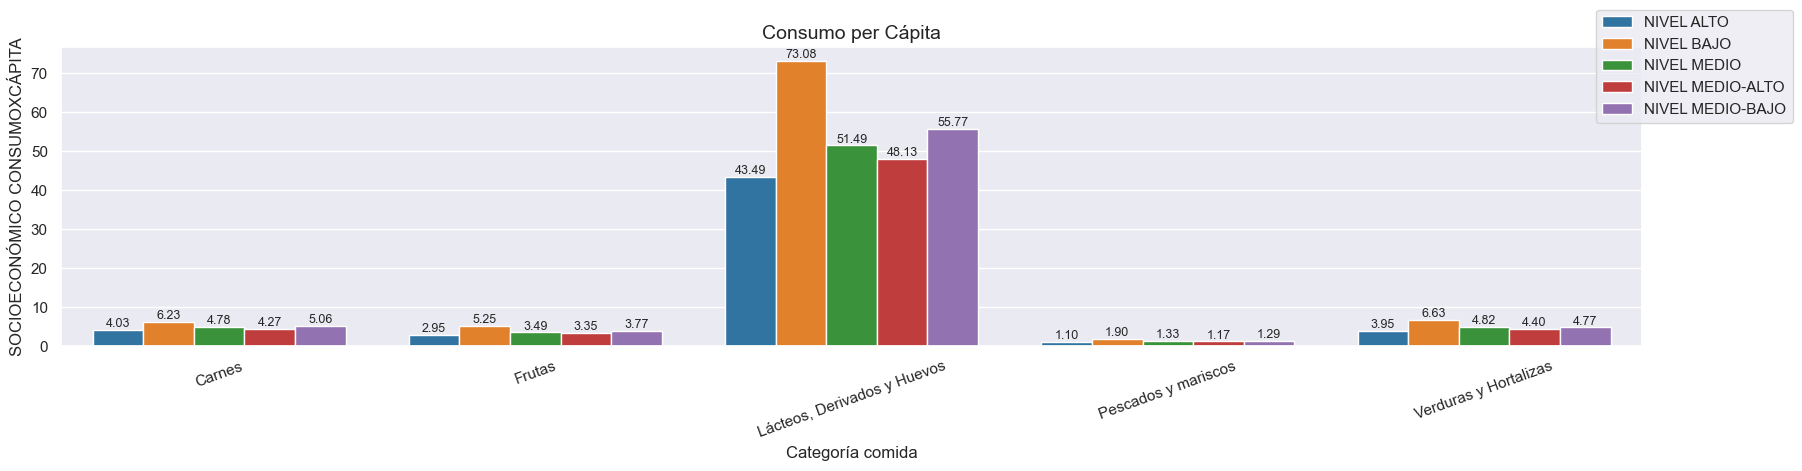

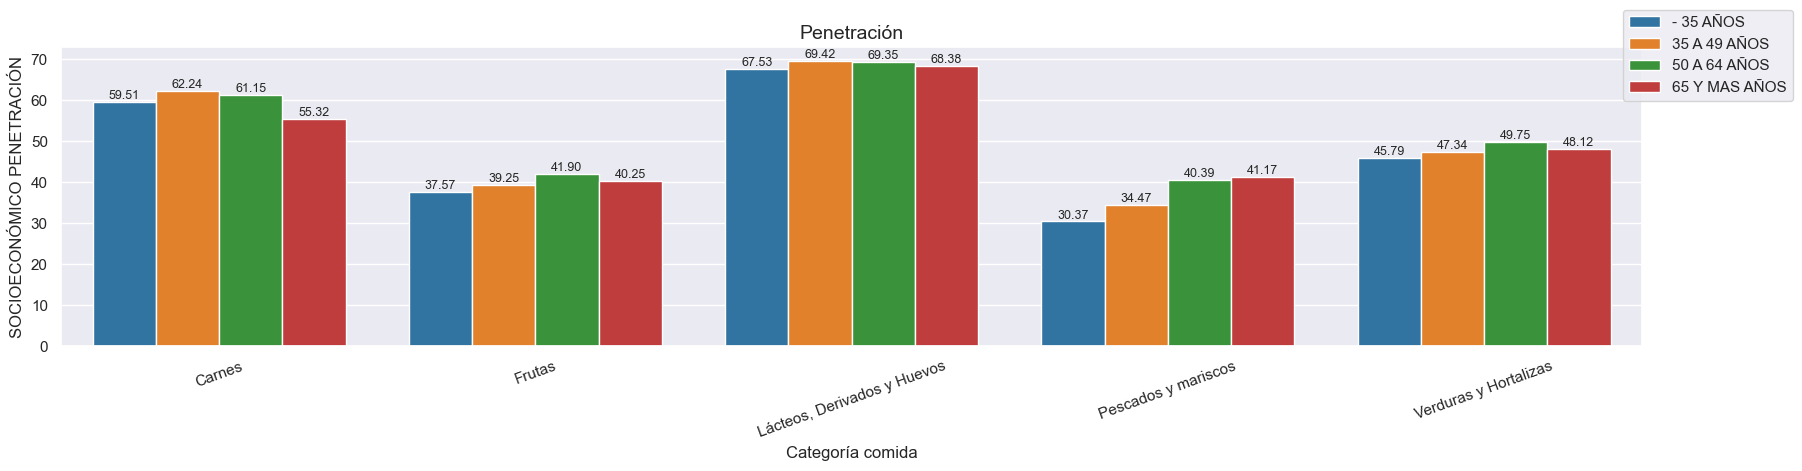

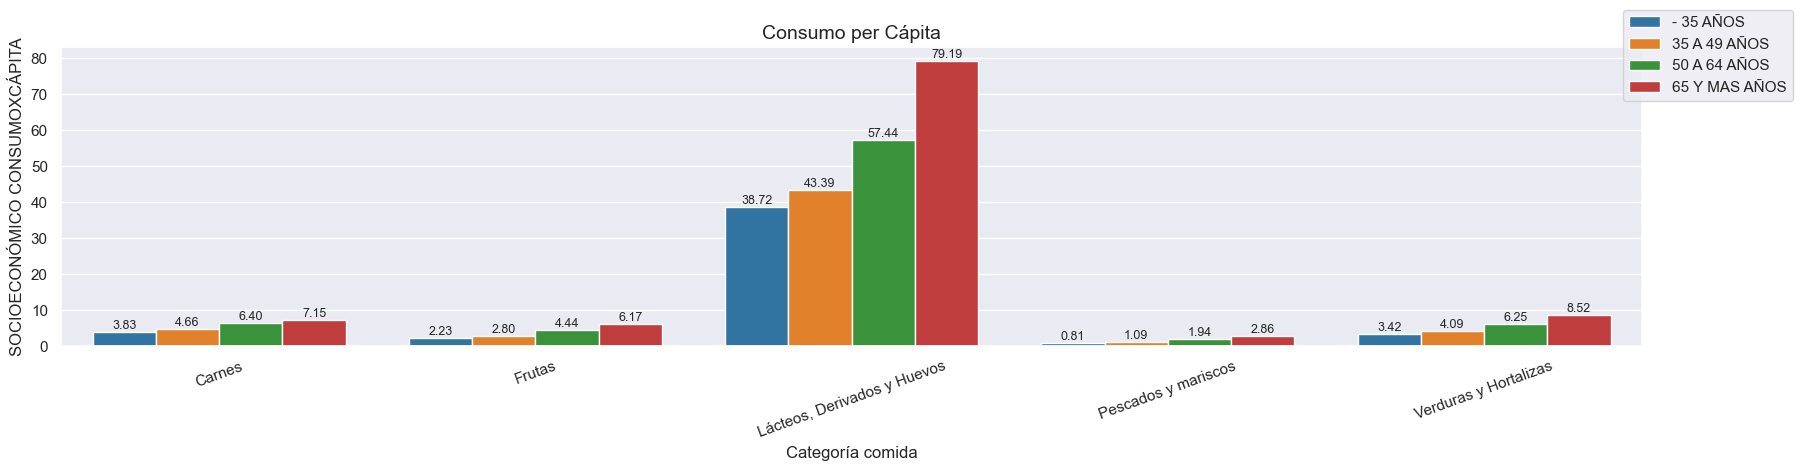

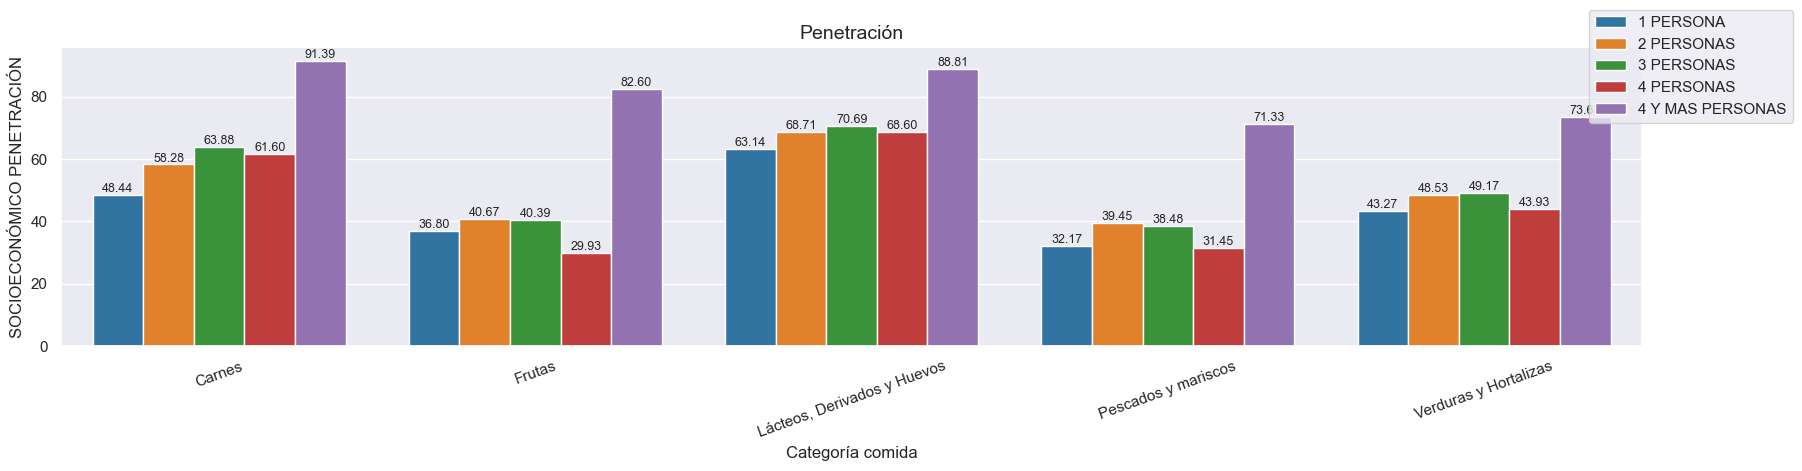

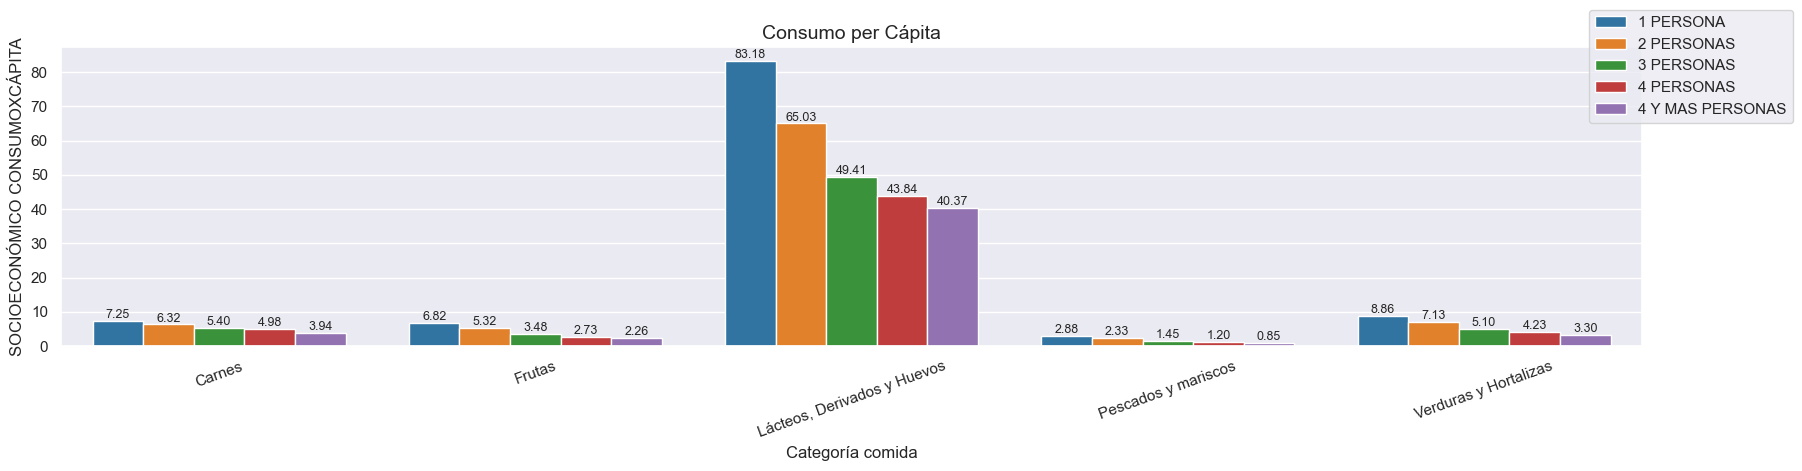

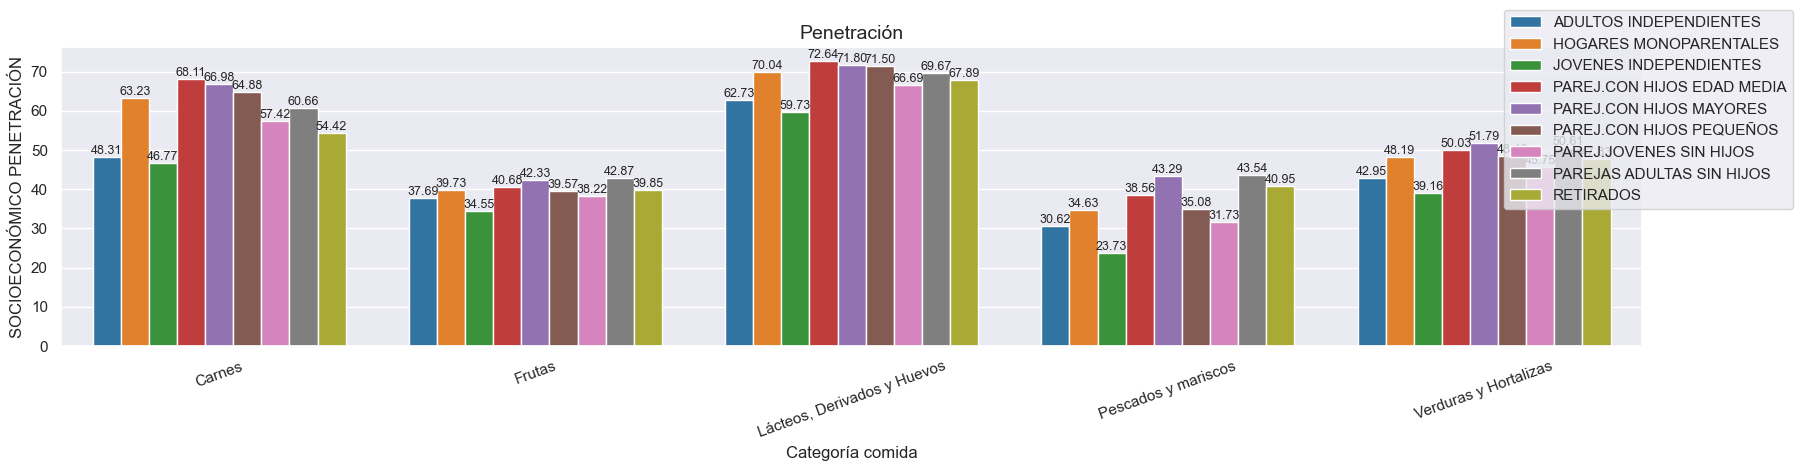

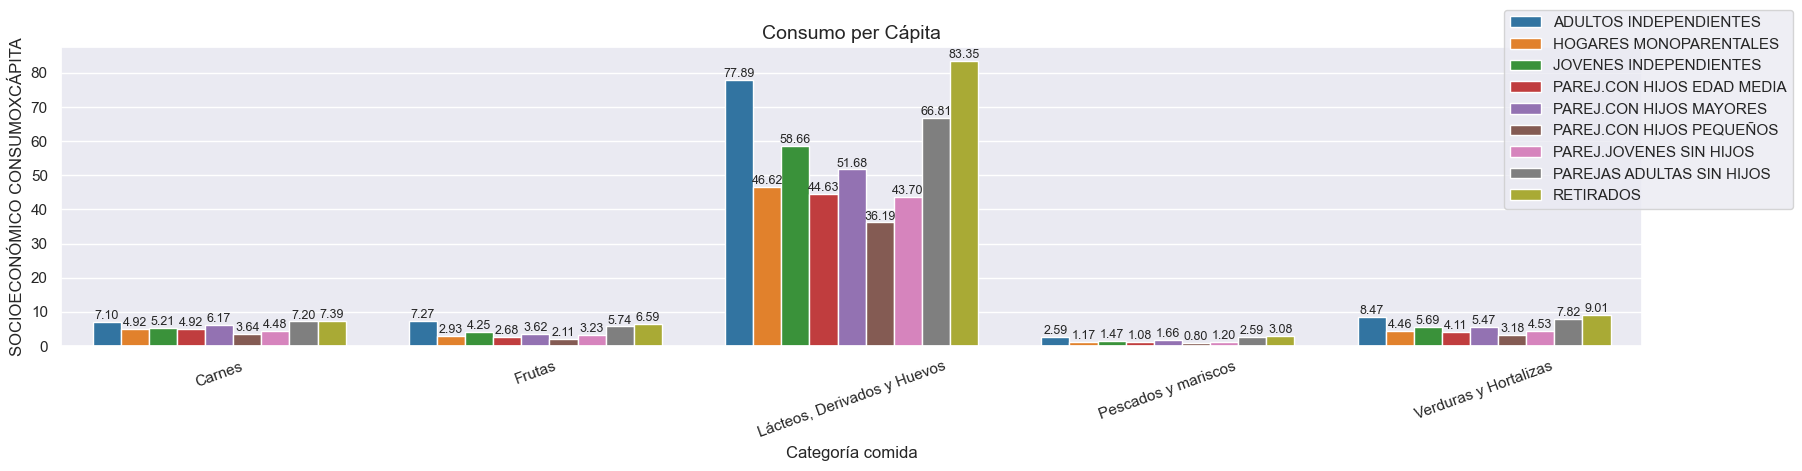

In [40]:
filtered_socioeconomico_df = final_socioeconomico_df[final_socioeconomico_df['Categoría'] == 1]

for i, lista in enumerate(lista_de_listas_socioeconómicos):
    df = filtered_socioeconomico_df[
        (filtered_socioeconomico_df['var_socioeconomica'].isin(lista)) &
        (filtered_socioeconomico_df['Nombre Refinado'].isin(clases_escogidas))
    ]
    
    df_grouped_penetracion = df.groupby(['var_socioeconomica', 'Categoría comida'])['SOCIOECONÓMICO PENETRACIÓN'].mean().reset_index()
    df_grouped_consumo = df.groupby(['var_socioeconomica', 'Categoría comida'])['SOCIOECONÓMICO CONSUMOXCÁPITA'].mean().reset_index()

    #1) Gráficos para la métrica Penetración
    plt.figure(figsize=(18, 5))
    ax1 = sns.barplot(data=df_grouped_penetracion, x='Categoría comida', y='SOCIOECONÓMICO PENETRACIÓN', hue='var_socioeconomica')
    ax1.set_title(f"Penetración", fontsize=14)
    ax1.tick_params(axis='x', rotation=20)
    for container in ax1.containers:
        ax1.bar_label(container, fmt='%.2f', label_type='edge', fontsize=9)
    ax1.legend(loc='upper right', bbox_to_anchor=(1.1, 1.15))
    
    plt.tight_layout()
    plt.show()

     #1) Gráficos para la métrica ConsumoXCápita
    plt.figure(figsize=(18, 5))
    ax2 = sns.barplot(data=df_grouped_consumo, x='Categoría comida', y='SOCIOECONÓMICO CONSUMOXCÁPITA', hue='var_socioeconomica')
    ax2.set_title(f"Consumo per Cápita", fontsize=14)
    ax2.tick_params(axis='x', rotation=20)
    for container in ax2.containers:
        ax2.bar_label(container, fmt='%.2f', label_type='edge', fontsize=9)
    ax2.legend(loc='upper right', bbox_to_anchor=(1.1,1.15))
    plt.tight_layout()
    plt.show()
